Epoch [1/1000], Loss: 983.8415
Epoch [10/1000], Loss: 89761.5635
Epoch [20/1000], Loss: 28648.4478
Epoch [30/1000], Loss: 1195.5504
Epoch [40/1000], Loss: 7533.3912
Epoch [50/1000], Loss: 1119.1930
Epoch [60/1000], Loss: 4083.1407
Epoch [70/1000], Loss: 2422.5833
Epoch [80/1000], Loss: 2030.1667
Epoch [90/1000], Loss: 4528.2172
Epoch [100/1000], Loss: 1467.0347
Epoch [110/1000], Loss: 36060.2303
Epoch [120/1000], Loss: 7838.2251
Epoch [130/1000], Loss: 19672.1532
Epoch [140/1000], Loss: 11895.0284
Epoch [150/1000], Loss: 6963.2244
Epoch [160/1000], Loss: 8996.8109
Epoch [170/1000], Loss: 109609.4887
Epoch [180/1000], Loss: 254440.1240
Epoch [190/1000], Loss: 1830642.1908
Epoch [200/1000], Loss: 1502.2402
Epoch [210/1000], Loss: 3592.7941
Epoch [220/1000], Loss: 13779.3306
Epoch [230/1000], Loss: 5876.1593
Epoch [240/1000], Loss: 3285.1258
Epoch [250/1000], Loss: 1704.6471
Epoch [260/1000], Loss: 3079.0224
Epoch [270/1000], Loss: 4173.3867
Epoch [280/1000], Loss: 751.6862
Epoch [290/100

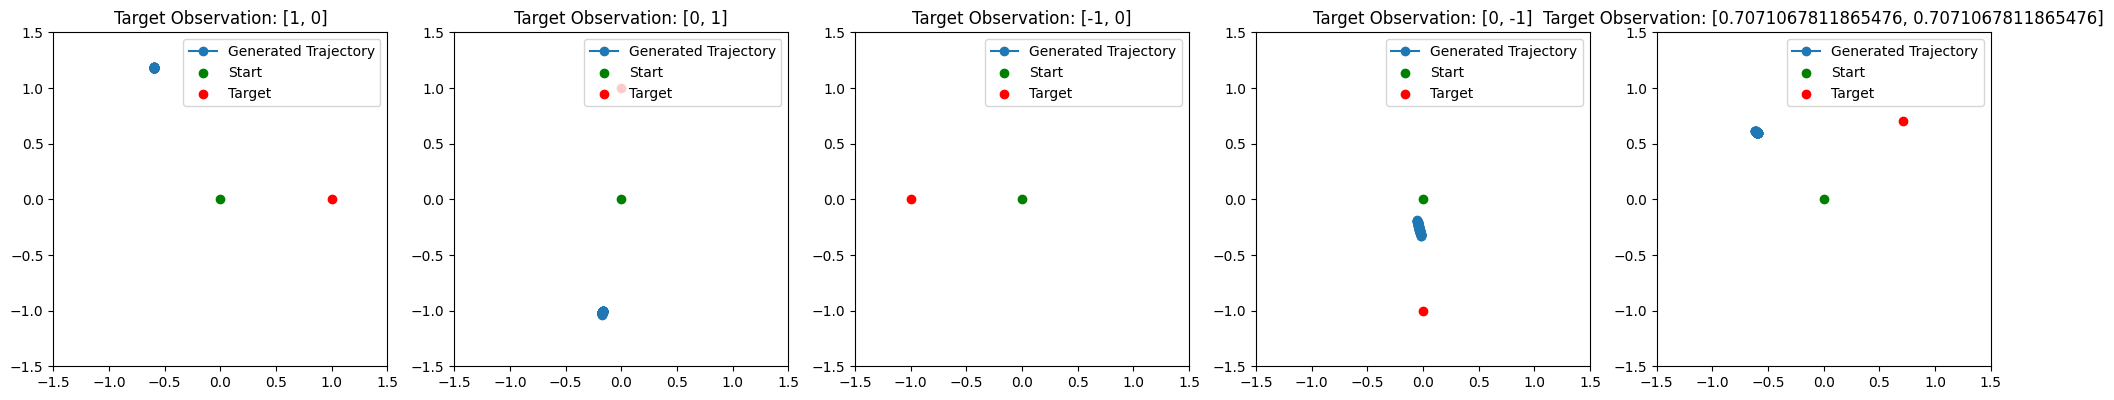

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
action_dim = 2       # Dimensions of action (e.g., 2D robot arm)
obs_dim = 2          # Dimensions of observation (e.g., target position)
hidden_dim = 32     # Hidden layer size
batch_size = 64*4      # Batch size for training
num_epochs = 1000     # Number of training epochs
learning_rate = 1e-5 # Learning rate
steps = 50           # Steps for inference denoising
data_size = 1000     # Size of the dataset

# Sinusoidal Positional Embedding for time encoding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim -1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Flow Matching Neural Network
class FlowMatchingNetwork(nn.Module):
    def __init__(self, action_dim, obs_dim, hidden_dim):
        super().__init__()
        self.obs_encoder = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.time_encoder = nn.Sequential(
            SinusoidalPosEmb(dim=hidden_dim),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.action_encoder = nn.Sequential(
            nn.Linear(action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x_t, obs, t):
        h_obs = self.obs_encoder(obs)
        h_time = self.time_encoder(t)
        h_action = self.action_encoder(x_t)
        # Reshape h_times to match the dimensions of h_obs and h_action
        h_time = h_time.squeeze(1)  # Remove the extra dimension
        h = torch.cat([h_obs, h_time, h_action], dim=-1)
        return self.decoder(h)

# Generate synthetic dataset
def generate_dataset(size):
    # Observations are points on a circle
    angles = np.linspace(0, 2 * np.pi, size)
    obs = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    # Actions are reaching from origin to the point on the circle
    actions = obs.copy()
    return torch.tensor(actions, dtype=torch.float32), torch.tensor(obs, dtype=torch.float32)

actions, observations = generate_dataset(data_size)
dataset = torch.utils.data.TensorDataset(actions, observations)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate model, optimizer, and loss function
model = FlowMatchingNetwork(action_dim, obs_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for actions_batch, obs_batch in data_loader:
        actions_batch = actions_batch.to(device)
        obs_batch = obs_batch.to(device)
        batch_size_curr = actions_batch.shape[0]

        # Sample random noise and timepoints
        noise = torch.randn_like(actions_batch).to(device)
        t = torch.rand(batch_size_curr, 1).to(device)

        # Create noisy actions
        x_t = t * actions_batch + (1 - t) * noise

        # Target denoising direction
        target = (actions_batch - noise) / (1 - t)

        # Predict denoising direction
        pred = model(x_t, obs_batch, t)

        # Compute loss
        loss = F.mse_loss(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size_curr
    avg_loss = total_loss / data_size
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization function
def visualize(model, obs_list):
    model.eval()
    fig, axs = plt.subplots(1, len(obs_list), figsize=(5 * len(obs_list), 5))
    if len(obs_list) == 1:
        axs = [axs]
    for idx, obs_np in enumerate(obs_list):
        obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0).to(device)
        # Start from random noise
        x = torch.randn(1, action_dim).to(device)
        trajectory = [x.squeeze().cpu().detach().numpy()]
        dt = 1.0 / steps
        # Gradually denoise
        for i in range(steps):
            t = torch.tensor([i * dt]).unsqueeze(1).to(device)
            dx = model(x, obs, t) * dt
            x = x + dx
            trajectory.append(x.squeeze().cpu().detach().numpy())
        trajectory = np.array(trajectory)
        # Plotting
        axs[idx].set_title(f'Target Observation: {obs_np}')
        axs[idx].plot(trajectory[:, 0], trajectory[:, 1], '-o', label='Generated Trajectory')
        axs[idx].scatter(0, 0, c='green', label='Start')
        axs[idx].scatter(obs_np[0], obs_np[1], c='red', label='Target')
        axs[idx].legend()
        axs[idx].set_xlim(-1.5, 1.5)
        axs[idx].set_ylim(-1.5, 1.5)
        axs[idx].set_aspect('equal', 'box')
    plt.show()

# Test the model with some observations
test_observations = [
    [1, 0],          # Point on the circle at 0 degrees
    [0, 1],          # 90 degrees
    [-1, 0],         # 180 degrees
    [0, -1],         # 270 degrees
    [np.sqrt(2)/2, np.sqrt(2)/2],  # 45 degrees
]

visualize(model, test_observations)

Epoch [1/1000], Loss: 1538.3314
Epoch [10/1000], Loss: 1427.6880
Epoch [20/1000], Loss: 2907.5026
Epoch [30/1000], Loss: 524.2314
Epoch [40/1000], Loss: 917.4862
Epoch [50/1000], Loss: 3373.2760
Epoch [60/1000], Loss: 38372.7442
Epoch [70/1000], Loss: 8824.0282
Epoch [80/1000], Loss: 22369.3105
Epoch [90/1000], Loss: 5019.9379
Epoch [100/1000], Loss: 17915.7074
Epoch [110/1000], Loss: 6973.1071
Epoch [120/1000], Loss: 412.8727
Epoch [130/1000], Loss: 1611.8506
Epoch [140/1000], Loss: 3551.9123
Epoch [150/1000], Loss: 766722.9605
Epoch [160/1000], Loss: 1508.5665
Epoch [170/1000], Loss: 6164.3940
Epoch [180/1000], Loss: 2676.5769
Epoch [190/1000], Loss: 12933.2640
Epoch [200/1000], Loss: 2462.5320
Epoch [210/1000], Loss: 116778.9836
Epoch [220/1000], Loss: 5121.6256
Epoch [230/1000], Loss: 10253.1607
Epoch [240/1000], Loss: 1505.9463
Epoch [250/1000], Loss: 1588.2157
Epoch [260/1000], Loss: 5728.6748
Epoch [270/1000], Loss: 918.9294
Epoch [280/1000], Loss: 2647.7869
Epoch [290/1000], Lo

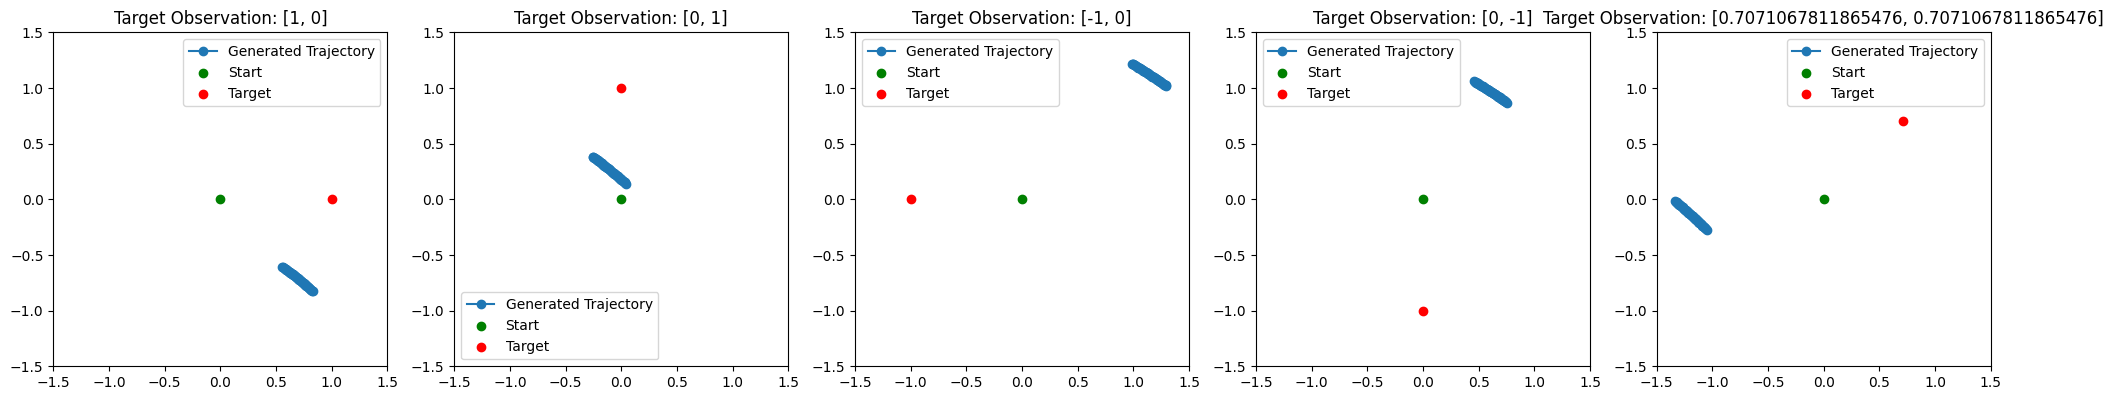

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
action_dim = 2       # Dimensions of action (e.g., 2D robot arm)
obs_dim = 2          # Dimensions of observation (e.g., target position)
hidden_dim = 32     # Hidden layer size
batch_size = 64*4      # Batch size for training
num_epochs = 1000     # Number of training epochs
learning_rate = 1e-5 # Learning rate
steps = 50           # Steps for inference denoising
data_size = 1000     # Size of the dataset

# Sinusoidal Positional Embedding for time encoding
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim -1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# Flow Matching Neural Network
class FlowMatchingNetwork(nn.Module):
    def __init__(self, action_dim, obs_dim, hidden_dim):
        super().__init__()
        self.obs_encoder = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.time_encoder = nn.Sequential(
            SinusoidalPosEmb(dim=hidden_dim),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.action_encoder = nn.Sequential(
            nn.Linear(action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x_t, obs, t):
        h_obs = self.obs_encoder(obs)
        h_time = self.time_encoder(t)
        h_action = self.action_encoder(x_t)
        # Reshape h_times to match the dimensions of h_obs and h_action
        h_time = h_time.squeeze(1)  # Remove the extra dimension
        h = torch.cat([h_obs, h_time, h_action], dim=-1)
        return self.decoder(h)

# Generate synthetic dataset
def generate_dataset(size):
    # Observations are points on a circle
    angles = np.linspace(0, 2 * np.pi, size)
    obs = np.stack([np.cos(angles), np.sin(angles)], axis=1)
    # Actions are reaching from origin to the point on the circle
    actions = obs.copy()
    return torch.tensor(actions, dtype=torch.float32), torch.tensor(obs, dtype=torch.float32)

actions, observations = generate_dataset(data_size)
dataset = torch.utils.data.TensorDataset(actions, observations)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate model, optimizer, and loss function
model = FlowMatchingNetwork(action_dim, obs_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for actions_batch, obs_batch in data_loader:
        actions_batch = actions_batch.to(device)
        obs_batch = obs_batch.to(device)
        batch_size_curr = actions_batch.shape[0]

        # Sample random noise and timepoints
        noise = torch.randn_like(actions_batch).to(device)
        t = torch.rand(batch_size_curr, 1).to(device)

        # Create noisy actions
        x_t = t * actions_batch + (1 - t) * noise

        # Target denoising direction
        target = (actions_batch - noise) / (1 - t)

        # Predict denoising direction
        pred = model(x_t, obs_batch, t)

        # Compute loss
        loss = F.mse_loss(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size_curr
    avg_loss = total_loss / data_size
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Visualization function
def visualize(model, obs_list):
    model.eval()
    fig, axs = plt.subplots(1, len(obs_list), figsize=(5 * len(obs_list), 5))
    if len(obs_list) == 1:
        axs = [axs]
    for idx, obs_np in enumerate(obs_list):
        obs = torch.tensor(obs_np, dtype=torch.float32).unsqueeze(0).to(device)
        # Start from random noise
        x = torch.randn(1, action_dim).to(device)
        trajectory = [x.squeeze().cpu().detach().numpy()]
        dt = 1.0 / steps
        # Gradually denoise
        for i in range(steps):
            t = torch.tensor([i * dt]).unsqueeze(1).to(device)
            dx = model(x, obs, t) * dt
            x = x + dx
            trajectory.append(x.squeeze().cpu().detach().numpy())
        trajectory = np.array(trajectory)
        # Plotting
        axs[idx].set_title(f'Target Observation: {obs_np}')
        axs[idx].plot(trajectory[:, 0], trajectory[:, 1], '-o', label='Generated Trajectory')
        axs[idx].scatter(0, 0, c='green', label='Start')
        axs[idx].scatter(obs_np[0], obs_np[1], c='red', label='Target')
        axs[idx].legend()
        axs[idx].set_xlim(-1.5, 1.5)
        axs[idx].set_ylim(-1.5, 1.5)
        axs[idx].set_aspect('equal', 'box')
    plt.show()

# Test the model with some observations
test_observations = [
    [1, 0],          # Point on the circle at 0 degrees
    [0, 1],          # 90 degrees
    [-1, 0],         # 180 degrees
    [0, -1],         # 270 degrees
    [np.sqrt(2)/2, np.sqrt(2)/2],  # 45 degrees
]

visualize(model, test_observations)

Epoch [10/1000], Loss: 1.9287
Epoch [20/1000], Loss: 2.0150
Epoch [30/1000], Loss: 1.9999
Epoch [40/1000], Loss: 2.0258
Epoch [50/1000], Loss: 2.0896
Epoch [60/1000], Loss: 1.9603
Epoch [70/1000], Loss: 2.0341
Epoch [80/1000], Loss: 2.0039
Epoch [90/1000], Loss: 1.9680
Epoch [100/1000], Loss: 2.0185
Epoch [110/1000], Loss: 2.0231
Epoch [120/1000], Loss: 2.0552
Epoch [130/1000], Loss: 2.0125
Epoch [140/1000], Loss: 1.9713
Epoch [150/1000], Loss: 2.0849
Epoch [160/1000], Loss: 2.0183
Epoch [170/1000], Loss: 2.0206
Epoch [180/1000], Loss: 2.0486
Epoch [190/1000], Loss: 1.9707
Epoch [200/1000], Loss: 1.9721
Epoch [210/1000], Loss: 2.0604
Epoch [220/1000], Loss: 2.0472
Epoch [230/1000], Loss: 1.9344
Epoch [240/1000], Loss: 1.9383
Epoch [250/1000], Loss: 1.9653
Epoch [260/1000], Loss: 2.0869
Epoch [270/1000], Loss: 2.0210
Epoch [280/1000], Loss: 2.0229
Epoch [290/1000], Loss: 2.0225
Epoch [300/1000], Loss: 2.0305
Epoch [310/1000], Loss: 2.0274
Epoch [320/1000], Loss: 2.0219
Epoch [330/1000],

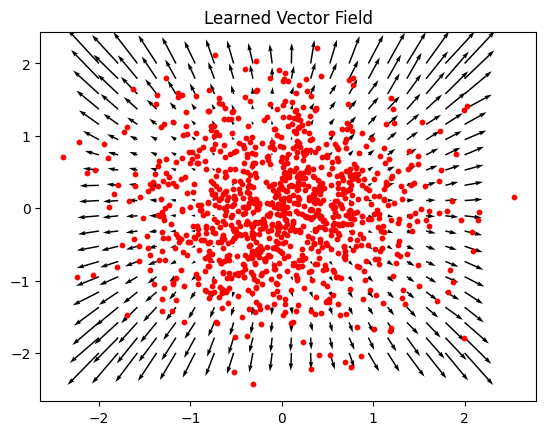

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate a Simple 2D Dataset
# For this example, let's create a dataset of points clustered
# around the origin (0, 0).
np.random.seed(0)
data = np.random.randn(1000, 2) * 0.8  # Adjust the scaling factor as needed

# 2. Define the Model Architecture
# We'll use a simple Multi-Layer Perceptron (MLP) as our
# vector field approximator.
class VectorFieldNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64) # Input: (x, y) + noise (2D)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2) # Output: Vector field (2D)
        self.relu = nn.ReLU()

    def forward(self, input):
        out = self.relu(self.fc1(input))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out


def flow_matching_loss(predicted_vf, target_vf):
    return torch.mean((predicted_vf - target_vf) ** 2)

def generate_noisy_data(data, timestep):
    noise = torch.randn_like(data)
    return timestep * data + (1 - timestep) * noise

def get_target_vf(noisy_data, data, timestep):
    return (noisy_data - data) / (1 - timestep)


model = VectorFieldNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

for epoch in range(num_epochs):
    for timestep in torch.linspace(0.1, 0.9, 10): # Sample timesteps
        noisy_data = generate_noisy_data(torch.tensor(data, dtype=torch.float32), timestep)
        target_vf = get_target_vf(noisy_data, torch.tensor(data, dtype=torch.float32), timestep)

        input_data = torch.cat([noisy_data, torch.randn_like(noisy_data)], dim=1)
        # Concatenate noisy data with additional noise
        predicted_vf = model(input_data)

        loss = flow_matching_loss(predicted_vf, target_vf)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Visualize the Learned Vector Field
# Generate a grid of points for visualization
x, y = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
grid_points = torch.tensor(np.stack((x.flatten(), y.flatten()), axis=1), dtype=torch.float32)

# Predict the vector field at the grid points
with torch.no_grad():
    input_grid = torch.cat([grid_points, torch.randn_like(grid_points)], dim=1)
    vector_field = model(input_grid).numpy()

# Plot the vector field
plt.quiver(grid_points[:, 0], grid_points[:, 1], vector_field[:, 0], vector_field[:, 1])
plt.scatter(data[:, 0], data[:, 1], s=10, c='red') # Plot the original data
plt.title('Learned Vector Field')
plt.show()

Epoch [10/100], Loss: 1.4451
Epoch [20/100], Loss: 1.5963
Epoch [30/100], Loss: 1.7194
Epoch [40/100], Loss: 1.4229
Epoch [50/100], Loss: 1.2998
Epoch [60/100], Loss: 1.2022
Epoch [70/100], Loss: 1.1647
Epoch [80/100], Loss: 1.0944
Epoch [90/100], Loss: 1.0774
Epoch [100/100], Loss: 1.0647


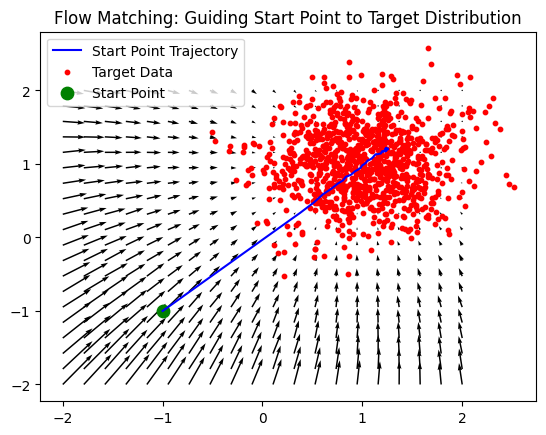

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Define Target Distribution and Start Point
target_center = np.array([1, 1])  # Target cluster center
target_data = np.random.randn(1000, 2) * 0.5 + target_center

start_point = np.array([-1, -1])

# 2. Define the Neural Network for the Vector Field
class VectorFieldNet(nn.Module):
    def __init__(self):
        super(VectorFieldNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # Adjusted input size
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)   # Output is a 2D vector field

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3.  Define Loss and Helper Functions
def generate_noisy_data(data, timestep):
    return timestep * data + (1 - timestep) * torch.randn_like(data)

def get_target_vf(noisy_data, target_data, timestep):
    return (target_data - noisy_data) / timestep

def flow_matching_loss(predicted_vf, target_vf):
    return torch.mean((predicted_vf - target_vf) ** 2)

# 4. Train the Model
model = VectorFieldNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

for epoch in range(num_epochs):
    for timestep in torch.linspace(0.1, 0.9, 10):
        noisy_data = generate_noisy_data(torch.tensor(target_data, dtype=torch.float32), timestep)
        target_vf = get_target_vf(noisy_data, torch.tensor(target_data, dtype=torch.float32), timestep)

        # Include the start point with noise for training
        input_data = torch.cat([torch.tensor(start_point[None, :]).repeat(noisy_data.shape, 1),
                               torch.randn_like(noisy_data)], dim=1)

        input_data = torch.cat([noisy_data, torch.randn_like(noisy_data)], dim=1) # Input: (x, y) + noise (4D)
        predicted_vf = model(input_data)

        loss = flow_matching_loss(predicted_vf, target_vf)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Visualize the Results
# Create a grid of points
x, y = np.meshgrid(np.linspace(-2, 2, 20), np.linspace(-2, 2, 20))
grid_points = np.stack((x.flatten(), y.flatten()), axis=1)
grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)

#  Add noise to the grid points (as in training)
grid_points_with_noise = torch.cat([grid_points_tensor, torch.randn_like(grid_points_tensor)], dim=1)
with torch.no_grad():
    vf = model(grid_points_with_noise)

# Plot the vector field
plt.quiver(grid_points[:, 0], grid_points[:, 1], vf[:, 0], vf[:, 1])

# Simulate the trajectory of the start point
trajectory = [start_point]
current_point = torch.tensor(start_point, dtype=torch.float32)
current_point = torch.tensor(start_point, dtype=torch.float32).unsqueeze(0) # Add unsqueeze(0)
for _ in range(50):
    with torch.no_grad():
        input_point = torch.cat([current_point, torch.randn(1, 2)], dim=1)
        vf = model(input_point)
        current_point = current_point + 0.1 * vf
        trajectory.append(current_point.numpy().squeeze())

trajectory = np.array(trajectory)
plt.plot(trajectory[:, 0], trajectory[:, 1], c='blue', label='Start Point Trajectory')
plt.scatter(target_data[:, 0], target_data[:, 1], c='red', marker='o', s=10, label='Target Data')
plt.scatter(start_point[0], start_point[1], c='green', marker='o', s=80, label='Start Point')
plt.legend()
plt.title("Flow Matching: Guiding Start Point to Target Distribution")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 1. Define Target Distribution and Start Point
target_center = np.array([1, 1])
target_data = np.random.randn(1000, 2) * 0.5 + target_center
start_point = np.array([-1, -1])

# 2. Model: Neural Network to Represent Vector Field
class VectorFieldNet(nn.Module):
    def __init__(self):
        super(VectorFieldNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)  # Input: 2D point + 2D noise
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)   # Output: 2D vector field

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 3. Helper Functions for CFM with OT Path
def ot_flow(x0, t, target_center):
    """Optimal Transport flow (Equation 22 in source [1])."""
    sigma_min = 0.1  # Minimum standard deviation
    return (1 - (1 - sigma_min) * t) * x0 + t * target_center

def get_target_vf(x, t, target_center):
    """Target vector field for OT path (Equation 21 in source [1])."""
    sigma_min = 0.1
    return (target_center - (1 - sigma_min) * x) / (1 - (1 - sigma_min) * t)

def flow_matching_loss(predicted_vf, target_vf):
    """Mean squared error loss."""
    return torch.mean((predicted_vf - target_vf)**2)

# 4. Training Loop
model = VectorFieldNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

for epoch in range(num_epochs):
    for timestep in torch.linspace(0.1, 0.9, 9):  # Sample t from [0.1, 0.9]
        # Sample noise and create input data
        noise = torch.randn(target_data.shape, 2)
        x0 = torch.tensor(start_point[None, :], dtype=torch.float32).repeat(target_data.shape, 1)
        x = ot_flow(x0, timestep, torch.tensor(target_center, dtype=torch.float32))
        input_data = torch.cat([x, noise], dim=1)

        # Compute target vector field and predicted vector field
        target_vf = get_target_vf(x, timestep, torch.tensor(target_center, dtype=torch.float32))
        predicted_vf = model(input_data)

        # Calculate loss and update model
        loss = flow_matching_loss(predicted_vf, target_vf)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Visualization: Vector Field and Trajectory
# Create a grid of points for visualizing the vector field
x, y = np.meshgrid(np.linspace(-2, 3, 20), np.linspace(-2, 3, 20))
grid_points = torch.tensor(np.stack((x, y), axis=2).reshape(-1, 2), dtype=torch.float32)

# Predict vector field at grid points
with torch.no_grad():
    vf = model(torch.cat([grid_points, torch.zeros_like(grid_points)], dim=1))

# Plot the vector field
plt.quiver(grid_points[:, 0].numpy(), grid_points[:, 1].numpy(),
           vf[:, 0].numpy(), vf[:, 1].numpy())
plt.scatter(target_data[:, 0], target_data[:, 1], s=5, label='Target Distribution')

# Simulate and plot trajectory of the start point
trajectory = [start_point]
current_point = torch.tensor(start_point, dtype=torch.float32)
for _ in range(50):
    with torch.no_grad():
        input_point = torch.cat([current_point, torch.randn(1, 2)], dim=1)
        vf = model(input_point)
        current_point = current_point + 0.1 * vf
        trajectory.append(current_point.numpy())

trajectory = np.array(trajectory)
plt.plot(trajectory[:, 0], trajectory[:, 1], c='blue', label='Start Point Trajectory')
plt.scatter(start_point, start_point[1], c='red', marker='o', s=80, label='Start Point')
plt.legend()
plt.title('Flow Matching with OT Path')
plt.show()

TypeError: randn() received an invalid combination of arguments - got (tuple, int), but expected one of:
 * (tuple of ints size, *, torch.Generator generator, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.Generator generator, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


  2%|▏         | 152/10000 [00:00<00:19, 505.51it/s]

Epoch 100, Loss: 5336.6489
Epoch 200, Loss: 3051.4451


  4%|▎         | 367/10000 [00:00<00:18, 521.54it/s]

Epoch 300, Loss: 7312.8198


  5%|▍         | 470/10000 [00:00<00:20, 476.01it/s]

Epoch 400, Loss: 29490.5293


  6%|▌         | 565/10000 [00:01<00:20, 462.20it/s]

Epoch 500, Loss: 10700.5908


  7%|▋         | 658/10000 [00:01<00:20, 448.81it/s]

Epoch 600, Loss: 1267.4873


  7%|▋         | 749/10000 [00:01<00:20, 442.76it/s]

Epoch 700, Loss: 1556.2498


  9%|▉         | 895/10000 [00:01<00:19, 468.69it/s]

Epoch 800, Loss: 2628.0225
Epoch 900, Loss: 3398.1636


 11%|█         | 1089/10000 [00:02<00:14, 594.83it/s]

Epoch 1000, Loss: 1218.0375
Epoch 1100, Loss: 8585.4434


 13%|█▎        | 1299/10000 [00:02<00:13, 665.82it/s]

Epoch 1200, Loss: 14718.1318
Epoch 1300, Loss: 17634.1641


 15%|█▌        | 1511/10000 [00:02<00:12, 670.94it/s]

Epoch 1400, Loss: 1751.0947
Epoch 1500, Loss: 271389.9062


 17%|█▋        | 1718/10000 [00:03<00:12, 670.21it/s]

Epoch 1600, Loss: 2623.7190
Epoch 1700, Loss: 1396.5891


 19%|█▉        | 1931/10000 [00:03<00:11, 688.58it/s]

Epoch 1800, Loss: 4802.7729
Epoch 1900, Loss: 6170.7393


 21%|██        | 2072/10000 [00:03<00:11, 694.01it/s]

Epoch 2000, Loss: 1469.3320
Epoch 2100, Loss: 6315.3506


 23%|██▎       | 2282/10000 [00:03<00:11, 680.70it/s]

Epoch 2200, Loss: 1765.8414
Epoch 2300, Loss: 1191245.2500


 25%|██▍       | 2492/10000 [00:04<00:10, 683.20it/s]

Epoch 2400, Loss: 1865.6597
Epoch 2500, Loss: 5331.6816


 27%|██▋       | 2703/10000 [00:04<00:10, 692.05it/s]

Epoch 2600, Loss: 1169.9709
Epoch 2700, Loss: 3162.9590


 29%|██▉       | 2917/10000 [00:04<00:10, 678.56it/s]

Epoch 2800, Loss: 3532.8784
Epoch 2900, Loss: 15353.0312


 31%|███▏      | 3128/10000 [00:05<00:10, 677.32it/s]

Epoch 3000, Loss: 4954.3828
Epoch 3100, Loss: 1509.7361


 33%|███▎      | 3341/10000 [00:05<00:09, 696.88it/s]

Epoch 3200, Loss: 83232.8516
Epoch 3300, Loss: 2865.0649


 35%|███▍      | 3482/10000 [00:05<00:09, 691.68it/s]

Epoch 3400, Loss: 4254.9917
Epoch 3500, Loss: 14507.6094


 37%|███▋      | 3687/10000 [00:06<00:09, 652.51it/s]

Epoch 3600, Loss: 4158.6543
Epoch 3700, Loss: 3686.9094


 39%|███▉      | 3895/10000 [00:06<00:08, 678.51it/s]

Epoch 3800, Loss: 57126.8594
Epoch 3900, Loss: 21094.8750


 41%|████      | 4106/10000 [00:06<00:08, 691.37it/s]

Epoch 4000, Loss: 14757.3232
Epoch 4100, Loss: 7481.7114


 43%|████▎     | 4315/10000 [00:06<00:08, 677.24it/s]

Epoch 4200, Loss: 3549443.7500
Epoch 4300, Loss: 71319.5781


 45%|████▌     | 4522/10000 [00:07<00:08, 671.38it/s]

Epoch 4400, Loss: 222574.3750
Epoch 4500, Loss: 190351.0469


 47%|████▋     | 4728/10000 [00:07<00:07, 678.96it/s]

Epoch 4600, Loss: 1723.4128
Epoch 4700, Loss: 5855.8745


 49%|████▉     | 4933/10000 [00:07<00:07, 675.48it/s]

Epoch 4800, Loss: 1878.9744
Epoch 4900, Loss: 1399.1996


 51%|█████     | 5072/10000 [00:08<00:07, 666.53it/s]

Epoch 5000, Loss: 1814.6980
Epoch 5100, Loss: 6610.5332


 53%|█████▎    | 5280/10000 [00:08<00:06, 680.16it/s]

Epoch 5200, Loss: 2130.7639
Epoch 5300, Loss: 2179.0786


 55%|█████▍    | 5488/10000 [00:08<00:06, 681.10it/s]

Epoch 5400, Loss: 13699.3760
Epoch 5500, Loss: 29713.7285


 57%|█████▋    | 5695/10000 [00:09<00:06, 649.96it/s]

Epoch 5600, Loss: 1317.0587
Epoch 5700, Loss: 15258.6318


 59%|█████▉    | 5905/10000 [00:09<00:06, 678.24it/s]

Epoch 5800, Loss: 1053.6794
Epoch 5900, Loss: 1360.1674


 61%|██████    | 6117/10000 [00:09<00:05, 690.51it/s]

Epoch 6000, Loss: 2313.7712
Epoch 6100, Loss: 30243.5918


 63%|██████▎   | 6328/10000 [00:09<00:05, 680.83it/s]

Epoch 6200, Loss: 13350.7998
Epoch 6300, Loss: 1290.6541


 65%|██████▌   | 6533/10000 [00:10<00:05, 663.40it/s]

Epoch 6400, Loss: 1701.2300
Epoch 6500, Loss: 79293.5391


 67%|██████▋   | 6672/10000 [00:10<00:04, 676.50it/s]

Epoch 6600, Loss: 1119.0327
Epoch 6700, Loss: 2926.3572


 69%|██████▉   | 6879/10000 [00:10<00:04, 683.32it/s]

Epoch 6800, Loss: 3327.9128
Epoch 6900, Loss: 2042.9487


 71%|███████   | 7083/10000 [00:11<00:04, 642.90it/s]

Epoch 7000, Loss: 15929.1543
Epoch 7100, Loss: 14595.8896


 73%|███████▎  | 7288/10000 [00:11<00:04, 664.98it/s]

Epoch 7200, Loss: 2014.8434
Epoch 7300, Loss: 4586.5928


 75%|███████▍  | 7495/10000 [00:11<00:03, 676.27it/s]

Epoch 7400, Loss: 25424.0234
Epoch 7500, Loss: 19809.7051


 76%|███████▋  | 7634/10000 [00:11<00:03, 659.65it/s]

Epoch 7600, Loss: 2139.2847


 78%|███████▊  | 7761/10000 [00:12<00:04, 543.62it/s]

Epoch 7700, Loss: 1552.1377


 79%|███████▊  | 7873/10000 [00:12<00:04, 529.84it/s]

Epoch 7800, Loss: 210578.6562
Epoch 7900, Loss: 1776.4441


 81%|████████  | 8088/10000 [00:12<00:03, 525.58it/s]

Epoch 8000, Loss: 2204.0557
Epoch 8100, Loss: 1314.5221


 82%|████████▏ | 8248/10000 [00:13<00:03, 508.60it/s]

Epoch 8200, Loss: 2170.1641


 84%|████████▎ | 8351/10000 [00:13<00:03, 492.27it/s]

Epoch 8300, Loss: 1088.4839


 85%|████████▍ | 8453/10000 [00:13<00:03, 497.57it/s]

Epoch 8400, Loss: 1396.6133


 86%|████████▌ | 8554/10000 [00:13<00:02, 489.45it/s]

Epoch 8500, Loss: 281610.9688


 87%|████████▋ | 8653/10000 [00:13<00:02, 476.43it/s]

Epoch 8600, Loss: 2219.4424


 87%|████████▋ | 8747/10000 [00:14<00:02, 437.54it/s]

Epoch 8700, Loss: 2382.7744


 89%|████████▉ | 8875/10000 [00:14<00:02, 539.85it/s]

Epoch 8800, Loss: 11005.5361
Epoch 8900, Loss: 2523.6785


 91%|█████████ | 9081/10000 [00:14<00:01, 636.01it/s]

Epoch 9000, Loss: 3407.2832
Epoch 9100, Loss: 1925.6971


 93%|█████████▎| 9284/10000 [00:15<00:01, 646.11it/s]

Epoch 9200, Loss: 2346.5884
Epoch 9300, Loss: 3909.2905


 95%|█████████▍| 9488/10000 [00:15<00:00, 660.77it/s]

Epoch 9400, Loss: 27530.8984
Epoch 9500, Loss: 5746.4126


 97%|█████████▋| 9700/10000 [00:15<00:00, 687.04it/s]

Epoch 9600, Loss: 3155.1228
Epoch 9700, Loss: 208580.8125


 99%|█████████▉| 9910/10000 [00:15<00:00, 694.66it/s]

Epoch 9800, Loss: 16417.7949
Epoch 9900, Loss: 5045367.0000


100%|██████████| 10000/10000 [00:16<00:00, 622.54it/s]


Epoch 10000, Loss: 11776.3105


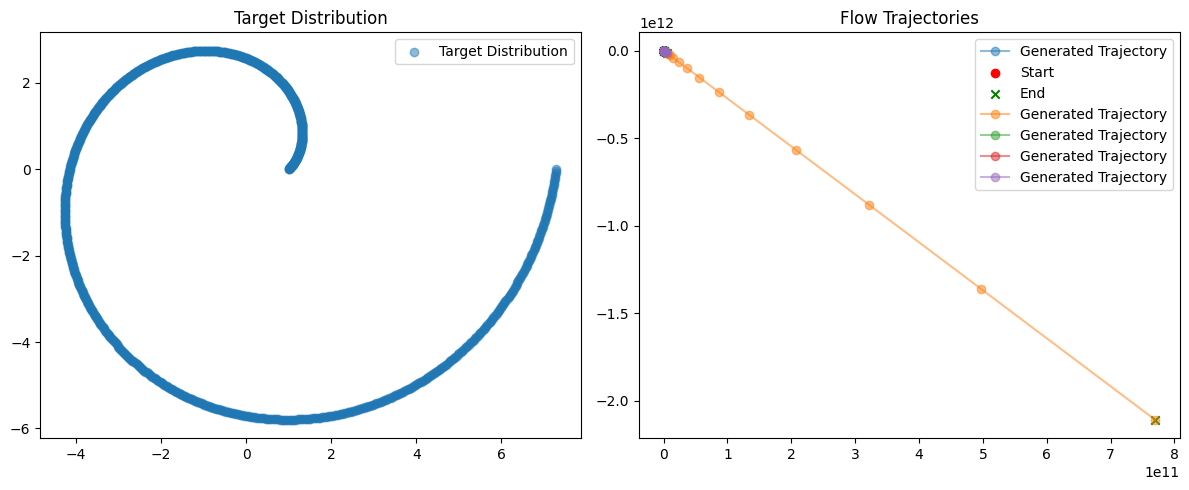

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class VectorField(nn.Module):
    """Neural network that learns the vector field for flow matching"""
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),  # +1 for time parameter
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x, t):
        # Concatenate input with time parameter
        xt = torch.cat([x, t.reshape(-1, 1)], dim=1)
        return self.net(xt)

class FlowMatching:
    def __init__(self, dim=2, hidden_dim=64, device='cpu'):
        self.dim = dim
        self.device = device
        self.vector_field = VectorField(dim, hidden_dim).to(device)
        self.optimizer = optim.Adam(self.vector_field.parameters(), lr=1e-3)

    def sample_noise(self, batch_size):
        """Sample from initial noise distribution"""
        return torch.randn(batch_size, self.dim).to(self.device)

    def interpolate(self, x0, x1, t):
        """Linear interpolation between noise and target"""
        return t * x1 + (1 - t) * x0

    def compute_target_vector(self, x0, x1, t):
        """Compute the target vector field"""
        return (x1 - x0) / (1 - t + 1e-5)

    def training_step(self, x1, batch_size=128):
        """Single training step"""
        self.vector_field.train()

        # Sample noise and time
        x0 = self.sample_noise(batch_size)
        t = torch.rand(batch_size, 1).to(self.device)

        # Compute interpolated point and target vector
        x_t = self.interpolate(x0, x1, t)
        target_vector = self.compute_target_vector(x0, x1, t)

        # Predict vector field
        predicted_vector = self.vector_field(x_t, t)

        # Compute loss
        loss = torch.mean((predicted_vector - target_vector) ** 2)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def generate(self, num_steps=100):
        """Generate samples using the learned vector field"""
        self.vector_field.eval()

        # Initialize from noise
        x = self.sample_noise(1)
        xs = [x.detach().cpu().numpy()]

        # Integration steps
        dt = 1.0 / num_steps
        for i in range(num_steps):
            t = torch.tensor([[i * dt]]).to(self.device)

            # Predict vector field and update
            with torch.no_grad():
                dx = self.vector_field(x, t)
                x = x + dx * dt

            xs.append(x.detach().cpu().numpy())

        return np.array(xs)

def visualize_flow(model, target_samples, num_trajectories=5):
    """Visualize flow matching trajectories"""
    plt.figure(figsize=(12, 5))

    # Plot target distribution
    plt.subplot(121)
    plt.scatter(target_samples[:, 0], target_samples[:, 1],
                alpha=0.5, label='Target Distribution')
    plt.title('Target Distribution')
    plt.legend()

    # Plot flow trajectories
    plt.subplot(122)
    for _ in range(num_trajectories):
        trajectory = model.generate()
        plt.plot(trajectory[:, 0, 0], trajectory[:, 0, 1],
                 alpha=0.5, marker='o', label='Generated Trajectory')
        plt.scatter(trajectory[0, 0, 0], trajectory[0, 0, 1],
                   c='r', marker='o', label='Start' if _ == 0 else None)
        plt.scatter(trajectory[-1, 0, 0], trajectory[-1, 0, 1],
                   c='g', marker='x', label='End' if _ == 0 else None)

    plt.title('Flow Trajectories')
    plt.legend()
    plt.tight_layout()
    return plt

# Example usage
def create_target_distribution(n_samples=1000):
    """Create a simple 2D target distribution (spiral)"""
    t = np.linspace(0, 2*np.pi, n_samples)
    r = t + 1
    x = r * np.cos(t)
    y = r * np.sin(t)
    return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)

# Training
if __name__ == "__main__":
    # Create target distribution
    target_samples = create_target_distribution()

    # Initialize model
    model = FlowMatching(dim=2)

    # Training loop
    n_epochs = 10000
    batch_size = 128

    for epoch in tqdm(range(n_epochs)):
        # Random batch from target distribution
        idx = np.random.choice(len(target_samples), batch_size)
        batch = target_samples[idx]

        # Training step
        loss = model.training_step(batch, batch_size)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

    # Visualize results
    plt = visualize_flow(model, target_samples.numpy())
    plt.show()

  2%|▏         | 116/5000 [00:00<00:39, 124.33it/s]

Epoch 100, Loss: 9188.2051


  4%|▎         | 187/5000 [00:01<00:47, 101.93it/s]


Early stopping at epoch 188


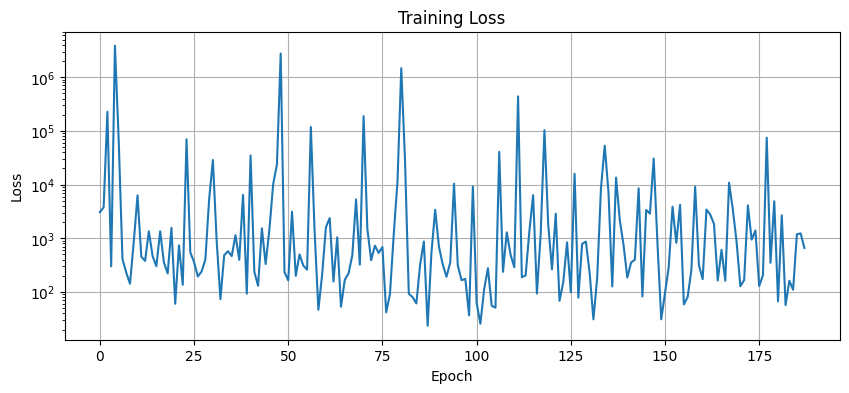

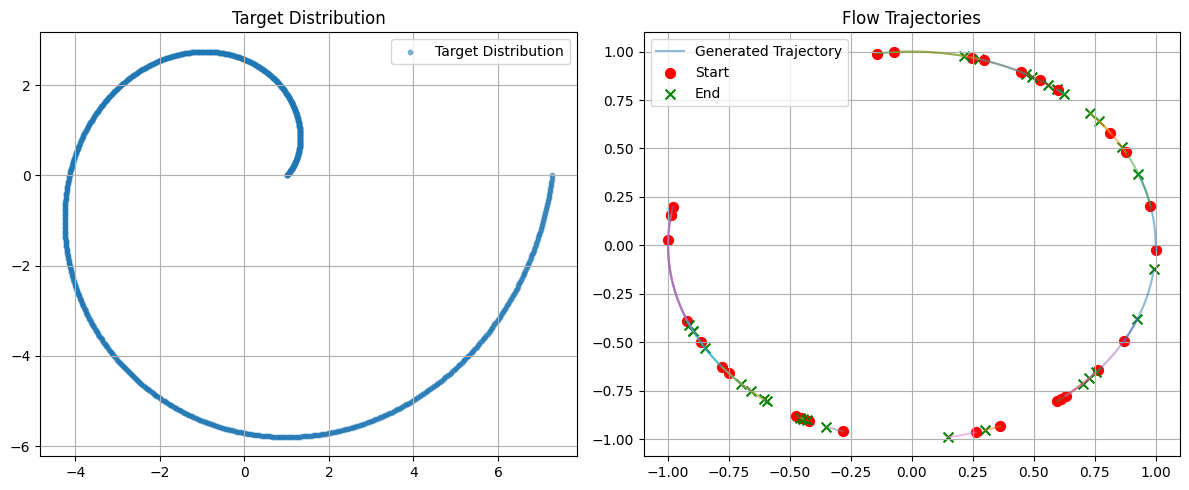

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x)

class VectorField(nn.Module):
    """Improved neural network that learns the vector field for flow matching"""
    def __init__(self, dim, hidden_dim=128):
        super().__init__()
        self.dim = dim

        # Time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Main network with residual connections and layer norm
        self.net = nn.ModuleList([
            nn.Sequential(
                LayerNorm(dim + hidden_dim),
                nn.Linear(dim + hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU()
            ),
            nn.Sequential(
                LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU()
            ),
            nn.Sequential(
                LayerNorm(hidden_dim),
                nn.Linear(hidden_dim, dim),
            )
        ])

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=0.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)

        # Concatenate input with time embedding
        h = torch.cat([x, t_emb], dim=-1)

        # Forward pass with residual connections
        for i, layer in enumerate(self.net):
            if i < len(self.net) - 1:
                h = layer(h) + h if h.shape == layer(h).shape else layer(h)
            else:
                h = layer(h)

        return h

class FlowMatching:
    def __init__(self, dim=2, hidden_dim=128, device='cpu'):
        self.dim = dim
        self.device = device
        self.vector_field = VectorField(dim, hidden_dim).to(device)

        # Use warmup and cosine annealing scheduler
        self.optimizer = optim.AdamW(
            self.vector_field.parameters(),
            lr=1e-4,
            weight_decay=1e-4,
            betas=(0.9, 0.99)
        )

    def sample_noise(self, batch_size):
        """Sample from initial noise distribution with normalization"""
        noise = torch.randn(batch_size, self.dim).to(self.device)
        return noise / torch.norm(noise, dim=-1, keepdim=True).clamp(min=1e-8)

    def interpolate(self, x0, x1, t):
        """Improved interpolation with normalization"""
        x_t = t * x1 + (1 - t) * x0
        return x_t / torch.norm(x_t, dim=-1, keepdim=True).clamp(min=1e-8)

    def compute_target_vector(self, x0, x1, t):
        """Compute the target vector field with stability improvements"""
        diff = x1 - x0
        norm = torch.norm(diff, dim=-1, keepdim=True).clamp(min=1e-8)
        return diff / (norm * (1 - t + 1e-5))

    def training_step(self, x1, batch_size=256):
        """Improved training step with gradient clipping"""
        self.vector_field.train()

        # Normalize target samples
        x1 = x1 / torch.norm(x1, dim=-1, keepdim=True).clamp(min=1e-8)

        # Sample noise and time
        x0 = self.sample_noise(batch_size)
        t = torch.rand(batch_size, 1).to(self.device)

        # Compute interpolated point and target vector
        x_t = self.interpolate(x0, x1, t)
        target_vector = self.compute_target_vector(x0, x1, t)

        # Predict vector field
        predicted_vector = self.vector_field(x_t, t)

        # Compute loss with stability term
        loss = torch.mean((predicted_vector - target_vector) ** 2)
        loss += 0.01 * torch.mean(torch.norm(predicted_vector, dim=-1))  # Regularization

        # Optimize with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.vector_field.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

    def generate(self, num_steps=100):
        """Generate samples with improved numerical integration"""
        self.vector_field.eval()

        # Initialize from noise
        x = self.sample_noise(1)
        xs = [x.detach().cpu().numpy()]

        # Integration steps with RK4 method
        dt = 1.0 / num_steps
        for i in range(num_steps):
            t = torch.tensor([[i * dt]]).to(self.device)

            # RK4 integration
            with torch.no_grad():
                k1 = self.vector_field(x, t)
                k2 = self.vector_field(x + 0.5 * dt * k1, t + 0.5 * dt)
                k3 = self.vector_field(x + 0.5 * dt * k2, t + 0.5 * dt)
                k4 = self.vector_field(x + dt * k3, t + dt)

                dx = (k1 + 2 * k2 + 2 * k3 + k4) / 6
                x = x + dx * dt

                # Normalize to prevent numerical instability
                x = x / torch.norm(x, dim=-1, keepdim=True).clamp(min=1e-8)

            xs.append(x.detach().cpu().numpy())

        return np.array(xs)


# def create_target_distribution(n_samples=1000):
#     """Create a more stable target distribution"""
#     t = np.linspace(0, 2*np.pi, n_samples)
#     r = 0.5 * (t + 1)  # Reduced scale
#     x = r * np.cos(t)
#     y = r * np.sin(t)
#     points = np.stack([x, y], axis=1)

#     # Normalize points
#     norms = np.linalg.norm(points, axis=1, keepdims=True)
#     points = points / np.maximum(norms, 1e-8)

#     return torch.tensor(points, dtype=torch.float32)


# Example usage
def create_target_distribution(n_samples=1000):
    """Create a simple 2D target distribution (spiral)"""
    t = np.linspace(0, 2*np.pi, n_samples)
    r = t + 1
    x = r * np.cos(t)
    y = r * np.sin(t)
    return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)


def visualize_flow(model, target_samples, num_trajectories=30):
    """Visualize flow matching trajectories with improved plotting"""
    plt.figure(figsize=(12, 5))

    # Plot target distribution
    plt.subplot(121)
    plt.scatter(target_samples[:, 0], target_samples[:, 1],
                alpha=0.5, label='Target Distribution', s=10)
    plt.title('Target Distribution')
    plt.legend()
    plt.grid(True)

    # Plot flow trajectories
    plt.subplot(122)
    for _ in range(num_trajectories):
        trajectory = model.generate()
        plt.plot(trajectory[:, 0, 0], trajectory[:, 0, 1],
                 alpha=0.5, label='Generated Trajectory' if _ == 0 else None)
        plt.scatter(trajectory[0, 0, 0], trajectory[0, 0, 1],
                   c='r', marker='o', s=50, label='Start' if _ == 0 else None)
        plt.scatter(trajectory[-1, 0, 0], trajectory[-1, 0, 1],
                   c='g', marker='x', s=50, label='End' if _ == 0 else None)

    plt.title('Flow Trajectories')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    return plt

# Training
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Create target distribution
    target_samples = create_target_distribution()

    # Initialize model
    model = FlowMatching(dim=2)

    # Training loop with early stopping
    n_epochs = 5000
    batch_size = 256
    best_loss = float('inf')
    patience = 100
    patience_counter = 0

    losses = []

    for epoch in tqdm(range(n_epochs)):
        # Random batch from target distribution
        idx = np.random.choice(len(target_samples), batch_size)
        batch = target_samples[idx]

        # Training step
        loss = model.training_step(batch, batch_size)
        losses.append(loss)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

        # Early stopping
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Plot loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Visualize results
    plt = visualize_flow(model, target_samples.numpy())
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import Tuple

class SimpleRoboticFlowMatching(nn.Module):
    def __init__(self, action_dim: int, hidden_dim: int = 128):
        """
        Simple implementation of flow matching for robotics actions

        Args:
            action_dim: Dimension of the robot's action space
            hidden_dim: Hidden dimension for the neural network
        """
        super().__init__()
        self.action_dim = action_dim

        # Simple encoder for robot state and observation
        self.encoder = nn.Sequential(
            nn.Linear(action_dim + 10, hidden_dim),  # +10 for dummy observation space
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Vector field prediction network
        self.vector_field = nn.Sequential(
            nn.Linear(hidden_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, noisy_actions: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        Predict the vector field for denoising

        Args:
            noisy_actions: Actions with noise added (B, action_dim)
            obs: Robot observations (B, obs_dim)

        Returns:
            Vector field predictions (B, action_dim)
        """
        # Encode observation
        encoded_obs = self.encoder(obs)

        # Concatenate encoded obs with noisy actions
        combined = torch.cat([encoded_obs, noisy_actions], dim=-1)

        # Predict vector field
        return self.vector_field(combined)

def sample_noise(batch_size: int, action_dim: int) -> torch.Tensor:
    """Generate random noise for flow matching"""
    return torch.randn(batch_size, action_dim)

def flow_matching_loss(
    model: nn.Module,
    clean_actions: torch.Tensor,
    obs: torch.Tensor,
    tau: float
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute flow matching loss

    Args:
        model: Flow matching model
        clean_actions: True robot actions
        obs: Robot observations
        tau: Flow matching timestep

    Returns:
        Loss value and noisy actions
    """
    batch_size = clean_actions.shape[0]

    # Sample noise
    epsilon = sample_noise(batch_size, model.action_dim)

    # Generate noisy actions using linear interpolation
    noisy_actions = tau * clean_actions + (1 - tau) * epsilon

    # Compute target vector field (denoising direction)
    target_field = epsilon - clean_actions

    # Predict vector field
    predicted_field = model(noisy_actions, obs)

    # Compute MSE loss
    loss = torch.mean((predicted_field - target_field) ** 2)

    return loss, noisy_actions

def generate_actions(
    model: nn.Module,
    obs: torch.Tensor,
    n_steps: int = 10
) -> torch.Tensor:
    """
    Generate actions using Euler integration

    Args:
        model: Flow matching model
        obs: Robot observations
        n_steps: Number of integration steps

    Returns:
        Generated actions
    """
    batch_size = obs.shape[0]
    delta = 1.0 / n_steps

    # Start from random noise
    current_actions = sample_noise(batch_size, model.action_dim)

    # Euler integration
    for step in range(n_steps):
        tau = step * delta
        vector_field = model(current_actions, obs)
        current_actions = current_actions + delta * vector_field

    return current_actions

# Example usage
def main():
    # Hyperparameters
    action_dim = 7  # Example: 7-DOF robot arm
    batch_size = 32
    n_epochs = 100

    # Create model and optimizer
    model = SimpleRoboticFlowMatching(action_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(n_epochs):
        # Generate dummy data
        obs = torch.randn(batch_size, action_dim + 10)  # Dummy observations
        clean_actions = torch.randn(batch_size, action_dim)  # Dummy true actions

        # Sample tau from beta distribution (emphasizing lower timesteps)
        tau = np.random.beta(1.0, 3.0)

        # Compute loss
        loss, noisy_actions = flow_matching_loss(model, clean_actions, obs, tau)

        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

    # Generate actions
    with torch.no_grad():
        test_obs = torch.randn(1, action_dim + 10)
        generated_actions = generate_actions(model, test_obs)
        print("\nGenerated actions:", generated_actions)

if __name__ == "__main__":
    main()

Epoch 10, Loss: 2.2087
Epoch 20, Loss: 2.0239
Epoch 30, Loss: 1.5496
Epoch 40, Loss: 2.1476
Epoch 50, Loss: 1.9828
Epoch 60, Loss: 1.7048
Epoch 70, Loss: 2.3528
Epoch 80, Loss: 1.4497
Epoch 90, Loss: 1.3803
Epoch 100, Loss: 1.5978

Generated actions: tensor([[-1.7263, -0.5804, -1.0034,  0.3193, -0.1590,  4.2996, -0.5529]])


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
import matplotlib.animation as animation

class Simple2DFlowMatching(nn.Module):
    def __init__(self, hidden_dim: int = 64):
        """
        Simple 2D flow matching implementation

        Args:
            hidden_dim: Hidden dimension for the neural network
        """
        super().__init__()

        # Simple network to predict the vector field
        self.vector_field_net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Predict the vector field at given points"""
        return self.vector_field_net(x)

def generate_circle_targets(n_points: int, radius: float = 1.0) -> torch.Tensor:
    """Generate target points in a circle"""
    theta = torch.linspace(0, 2*np.pi, n_points)
    x = radius * torch.cos(theta)
    y = radius * torch.sin(theta)
    return torch.stack([x, y], dim=1)

def generate_two_circles_targets(n_points: int) -> torch.Tensor:
    """Generate target points in two circles"""
    circle1 = generate_circle_targets(n_points//2, radius=1.0) + torch.tensor([-1.5, 0.0])
    circle2 = generate_circle_targets(n_points//2, radius=1.0) + torch.tensor([1.5, 0.0])
    return circle1 #torch.cat([circle1, circle2], dim=0)

def train_flow_matching(
    model: nn.Module,
    target_points: torch.Tensor,
    n_epochs: int = 10000,
    batch_size: int = 100,
    lr: float = 1e-3,
    device: str = 'cpu'
) -> list:
    """Train the flow matching model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(n_epochs):
        # Sample random noise
        noise = torch.randn(batch_size, 2, device=device)

        # Sample random timesteps
        tau = torch.rand(batch_size, 1, device=device)

        # Sample target points
        idx = torch.randint(0, len(target_points), (batch_size,))
        targets = target_points[idx]

        # Generate noisy points using linear interpolation
        noisy_points = tau * targets + (1 - tau) * noise

        # Compute target vector field (denoising direction)
        target_field = noise - targets

        # Predict vector field
        predicted_field = model(noisy_points)

        # Compute loss
        loss = torch.mean((predicted_field - target_field) ** 2)

        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    return losses

def generate_trajectory(
    model: nn.Module,
    initial_points: torch.Tensor,
    n_steps: int = 50,
    device: str = 'cpu'
) -> torch.Tensor:
    """Generate trajectory using Euler integration"""
    with torch.no_grad():
        current_points = initial_points.clone()
        trajectory = [current_points.clone()]

        dt = 1.0 / n_steps
        for _ in range(n_steps):
            vector_field = model(current_points)
            current_points = current_points + dt * vector_field
            trajectory.append(current_points.clone())

    return torch.stack(trajectory)

def visualize_flow(model, target_points, n_points=500):
    """Visualize the flow field and trajectories"""
    # Create grid of points
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    # Compute vector field
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    with torch.no_grad():
        vectors = model(grid_points)
    U = vectors[:, 0].numpy().reshape(X.shape)
    V = vectors[:, 1].numpy().reshape(X.shape)

    # Generate random initial points
    initial_points = torch.randn(n_points, 2)
    trajectory = generate_trajectory(model, initial_points)

    # Create animation
    fig, ax = plt.subplots(figsize=(10, 10))

    def animate(frame):
        ax.clear()

        # Plot vector field
        ax.quiver(X, Y, U, V, alpha=0.3)

        # Plot target points
        ax.scatter(target_points[:, 0], target_points[:, 1],
                  c='red', marker='*', s=100, label='Targets')

        # Plot current points
        ax.scatter(trajectory[frame, :, 0], trajectory[frame, :, 1],
                  c='blue', alpha=0.5, label='Points')

        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title(f'Flow Matching Evolution (Step {frame})')
        ax.legend()

    ani = animation.FuncAnimation(fig, animate, frames=len(trajectory),
                                interval=50, repeat=True)
    plt.close()
    return ani

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Create model
    model = Simple2DFlowMatching()

    # Generate target points (two circles pattern)
    target_points = generate_two_circles_targets(n_points=50)

    # Train model
    losses = train_flow_matching(model, target_points, n_epochs=10000)

    # Create visualization
    ani = visualize_flow(model, target_points)

    # Save animation
    ani.save('flow_matching.gif', writer='pillow')

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.savefig('training_loss.png')
    plt.close()

if __name__ == "__main__":
    main()

Epoch 100, Loss: 1.3320
Epoch 200, Loss: 1.4843
Epoch 300, Loss: 1.3307
Epoch 400, Loss: 1.2469
Epoch 500, Loss: 1.2205
Epoch 600, Loss: 1.1535
Epoch 700, Loss: 1.2502
Epoch 800, Loss: 1.1622
Epoch 900, Loss: 1.2102
Epoch 1000, Loss: 1.1179
Epoch 1100, Loss: 1.1614
Epoch 1200, Loss: 1.1785
Epoch 1300, Loss: 1.1349
Epoch 1400, Loss: 1.1414
Epoch 1500, Loss: 1.4692
Epoch 1600, Loss: 1.1548
Epoch 1700, Loss: 1.1522
Epoch 1800, Loss: 1.1447
Epoch 1900, Loss: 1.0615
Epoch 2000, Loss: 1.2098
Epoch 2100, Loss: 1.1013
Epoch 2200, Loss: 0.9639
Epoch 2300, Loss: 1.3194
Epoch 2400, Loss: 1.3003
Epoch 2500, Loss: 1.2413
Epoch 2600, Loss: 1.2323
Epoch 2700, Loss: 1.0995
Epoch 2800, Loss: 1.1593
Epoch 2900, Loss: 1.1008
Epoch 3000, Loss: 1.0234
Epoch 3100, Loss: 1.3246
Epoch 3200, Loss: 1.0584
Epoch 3300, Loss: 1.1945
Epoch 3400, Loss: 1.0131
Epoch 3500, Loss: 1.1949
Epoch 3600, Loss: 1.1693
Epoch 3700, Loss: 1.3505
Epoch 3800, Loss: 1.0224
Epoch 3900, Loss: 1.2537
Epoch 4000, Loss: 1.2590
Epoch 410

  5%|▍         | 70/1500 [00:00<00:04, 344.92it/s]

Step 100, Loss: 0.1475


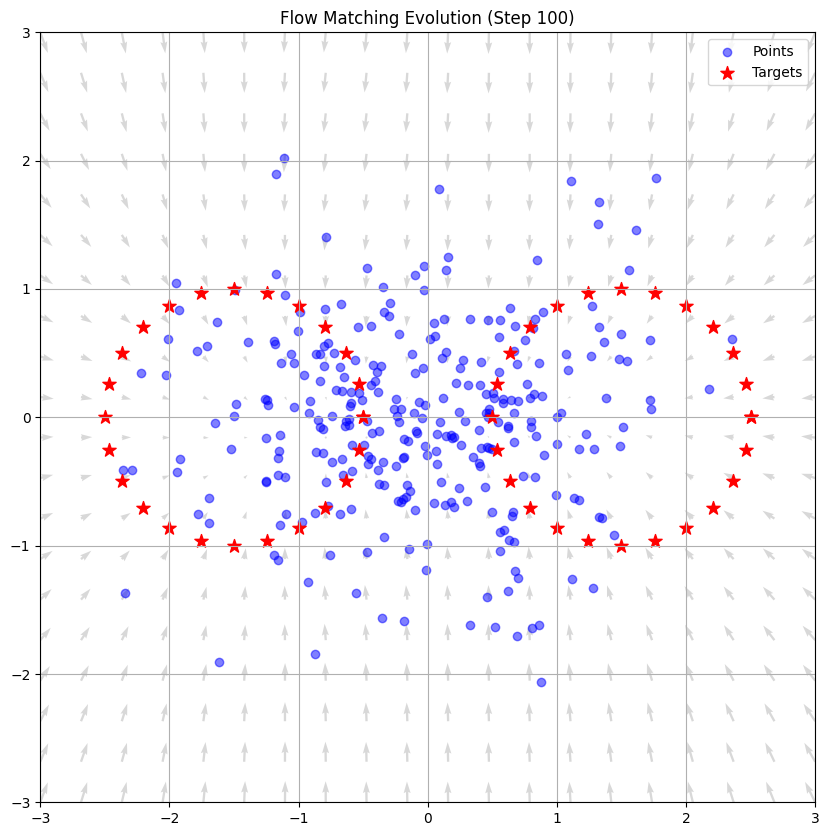

 12%|█▏        | 175/1500 [00:00<00:06, 211.16it/s]

Step 200, Loss: 0.1301


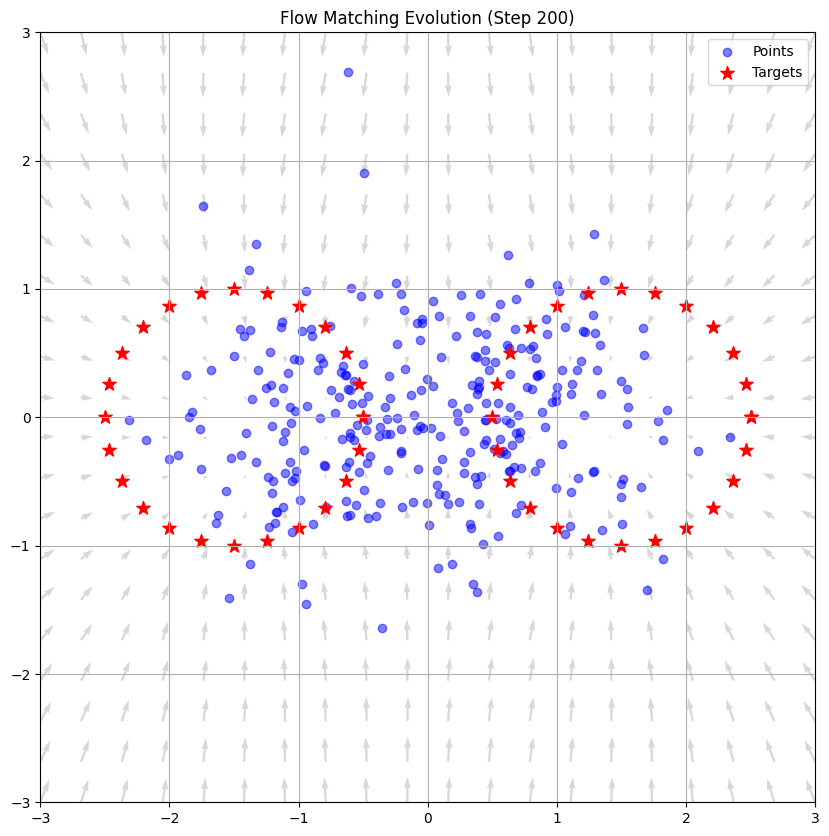

 18%|█▊        | 271/1500 [00:01<00:06, 187.68it/s]

Step 300, Loss: 0.1119


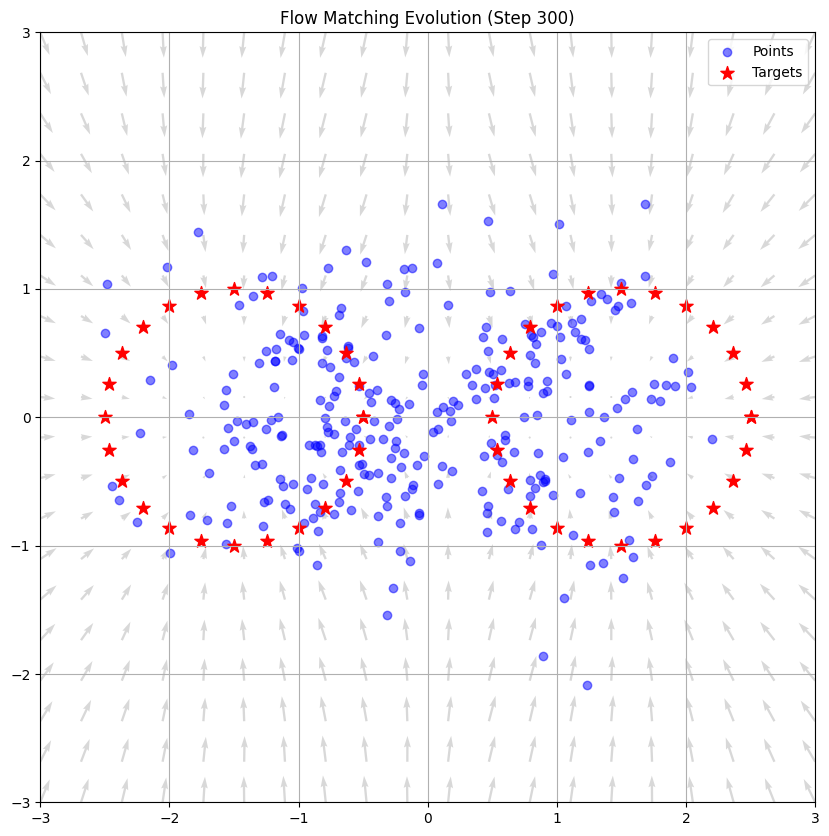

 27%|██▋       | 398/1500 [00:02<00:05, 212.87it/s]

Step 400, Loss: 0.1013


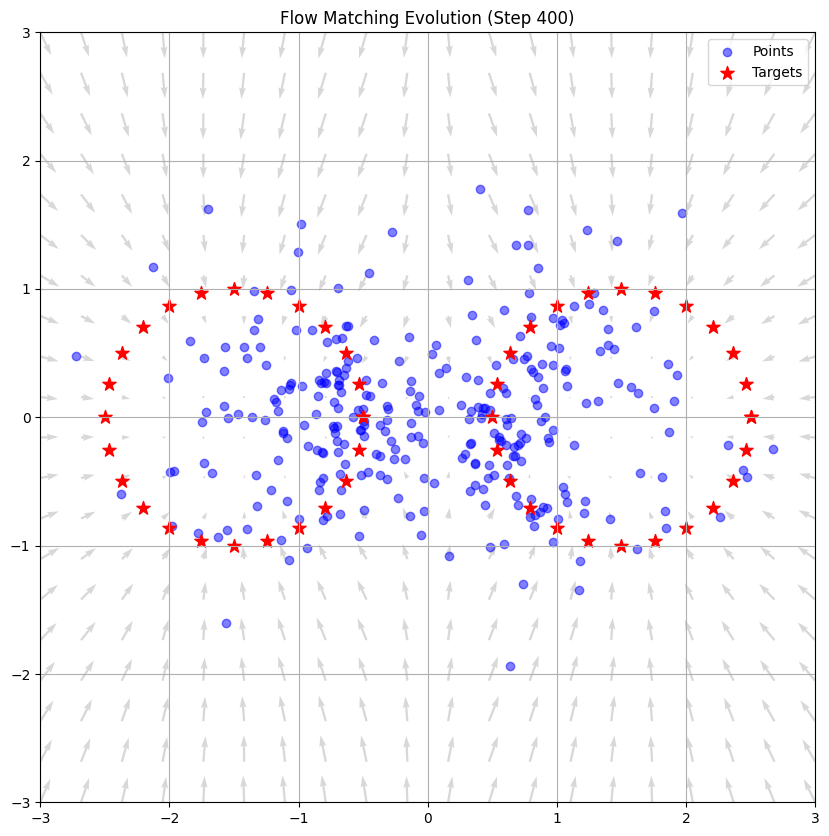

 33%|███▎      | 496/1500 [00:02<00:05, 191.34it/s]

Step 500, Loss: 0.0925


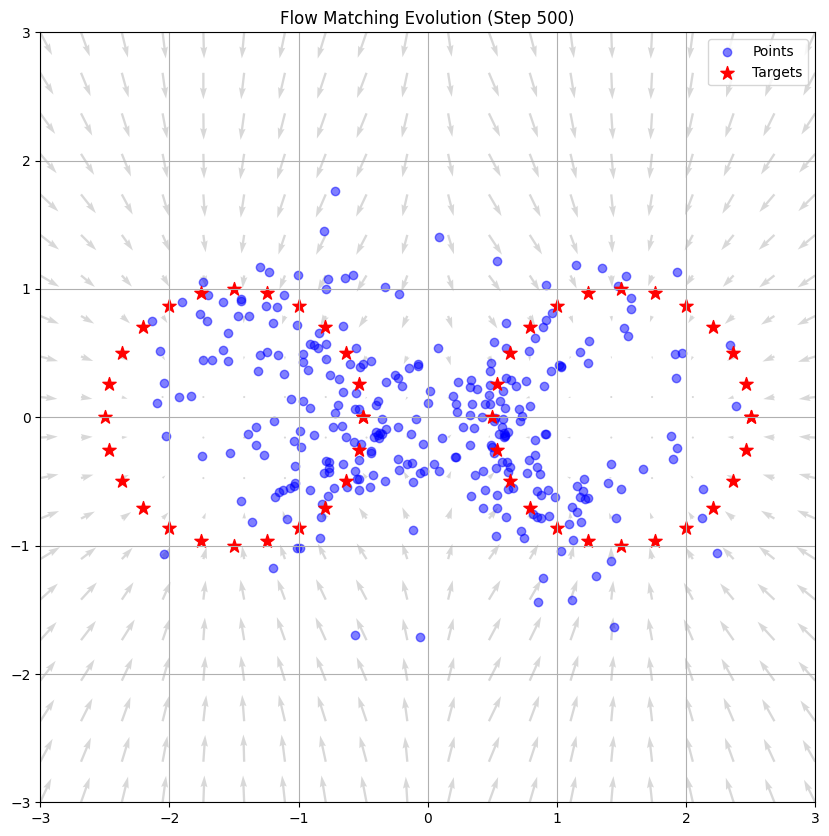

 39%|███▉      | 591/1500 [00:03<00:04, 183.61it/s]

Step 600, Loss: 0.0907


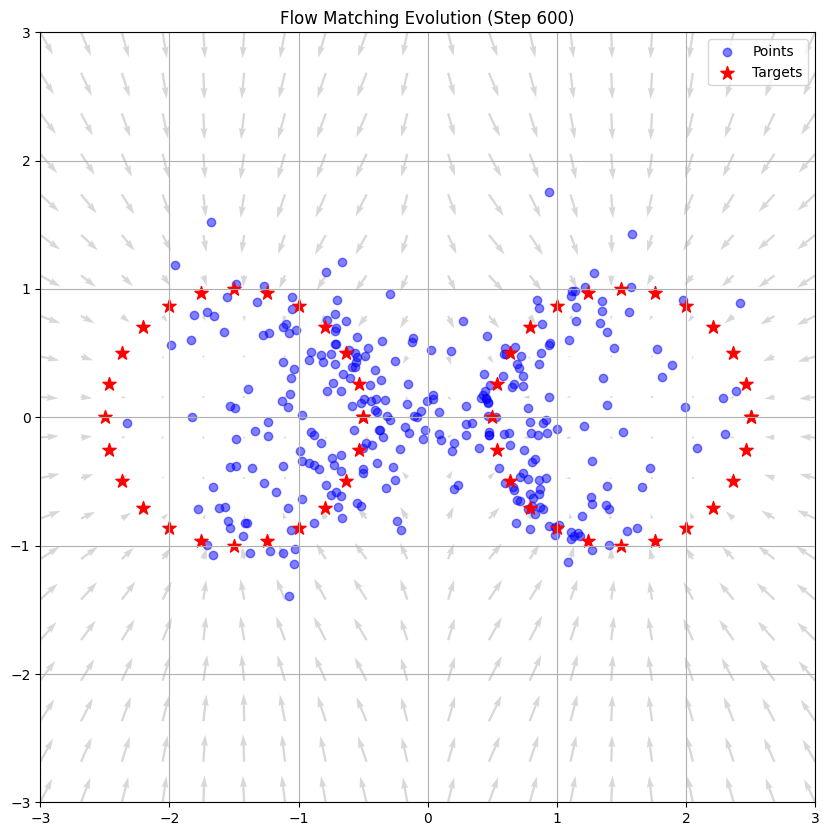

 46%|████▌     | 687/1500 [00:04<00:04, 180.45it/s]

Step 700, Loss: 0.0831


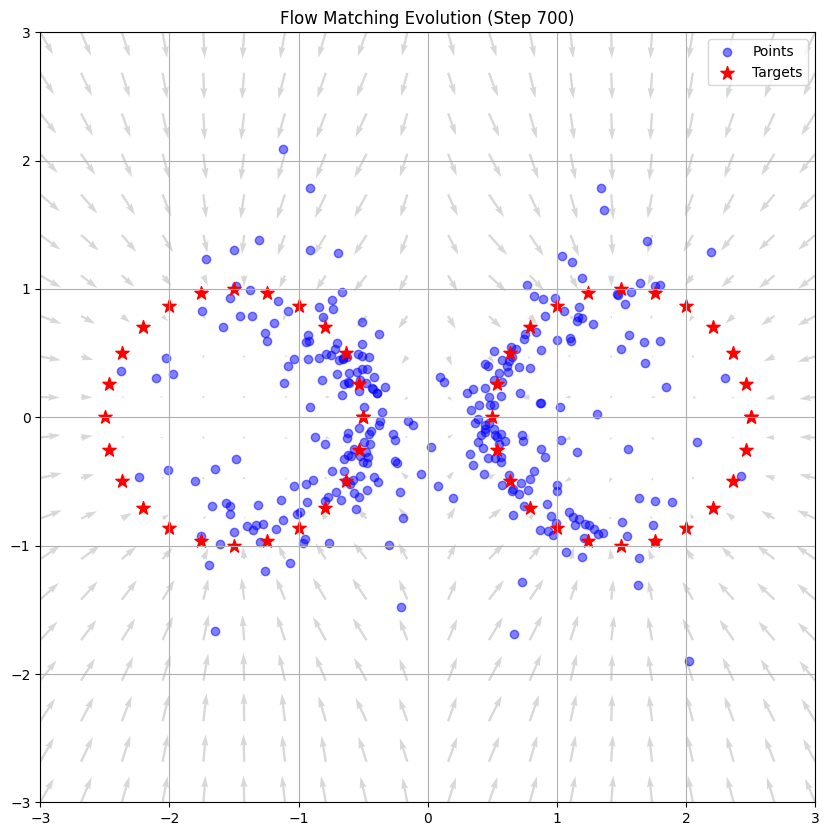

 52%|█████▏    | 783/1500 [00:04<00:03, 180.19it/s]

Step 800, Loss: 0.0687


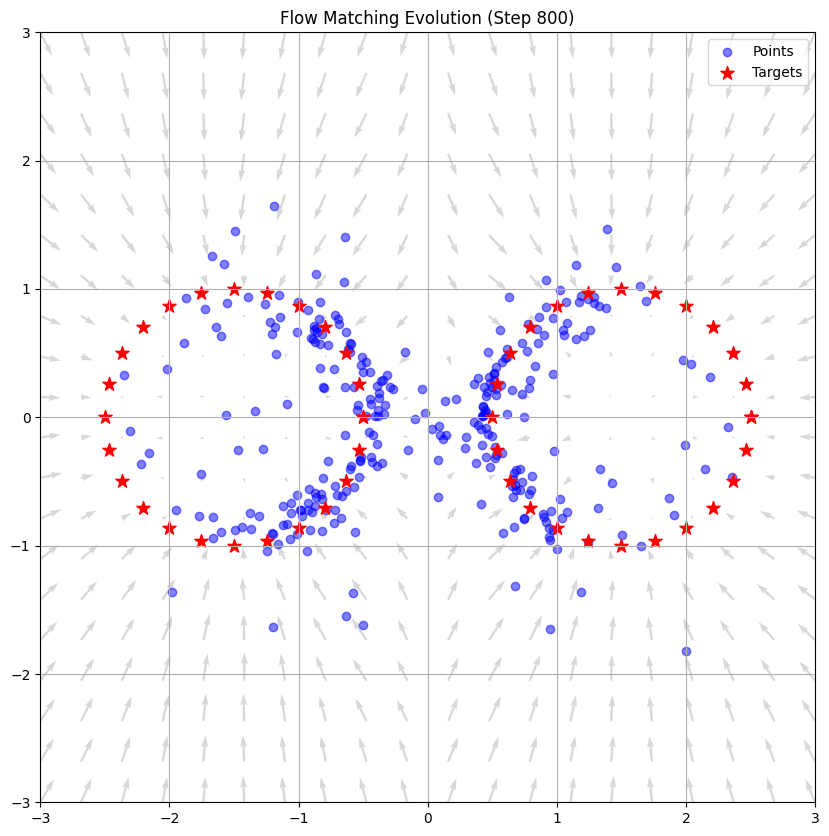

 58%|█████▊    | 875/1500 [00:05<00:03, 176.21it/s]

Step 900, Loss: 0.0620


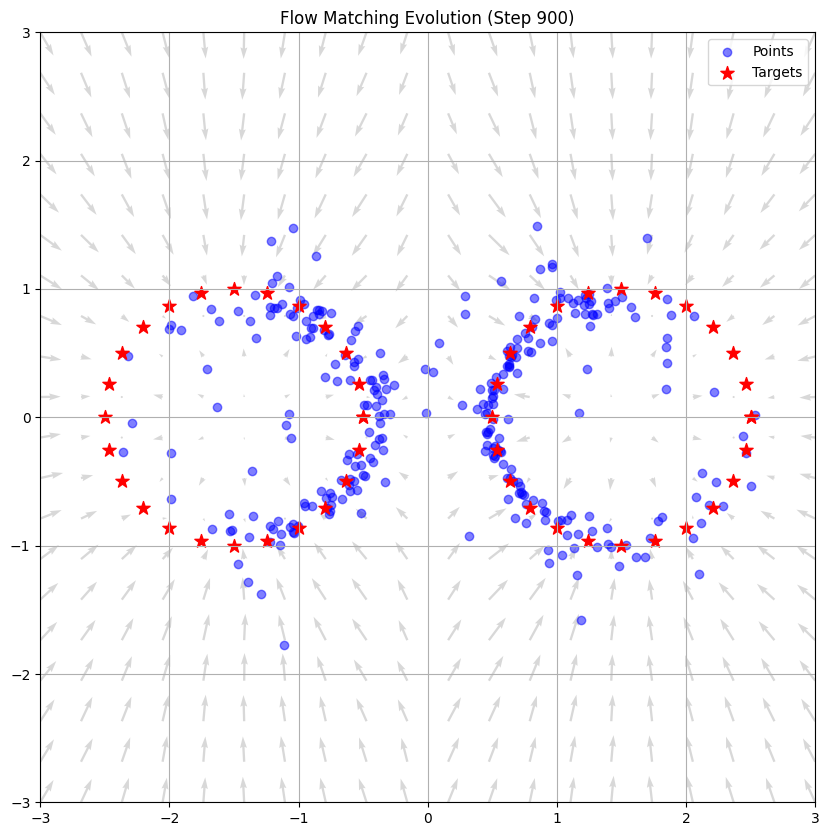

 66%|██████▌   | 986/1500 [00:06<00:02, 187.77it/s]

Step 1000, Loss: 0.0604


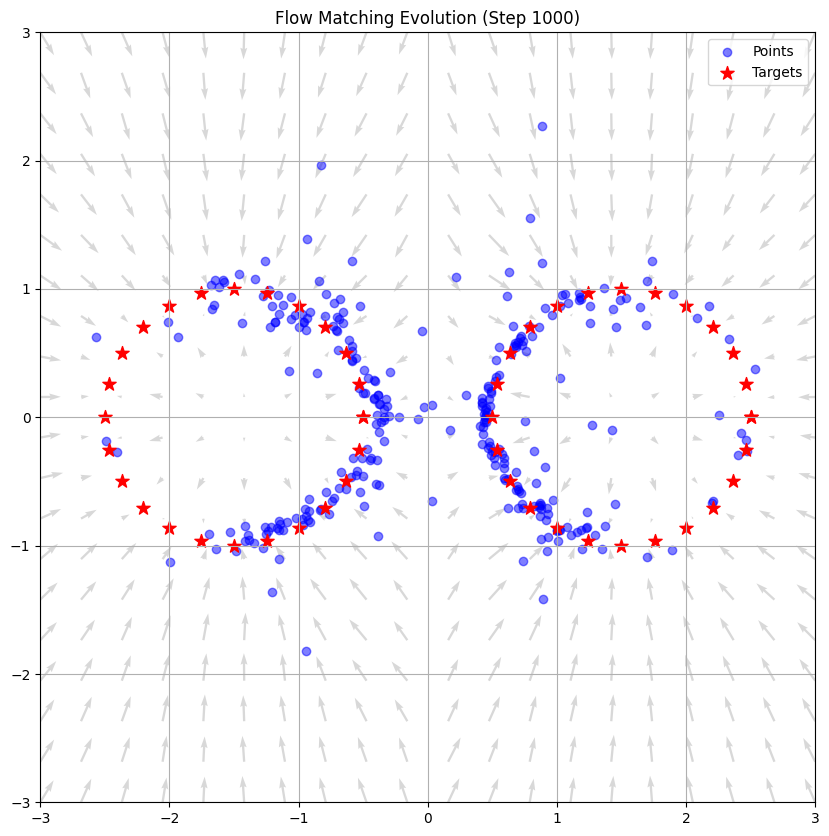

 72%|███████▏  | 1076/1500 [00:07<00:02, 172.21it/s]

Step 1100, Loss: 0.0467


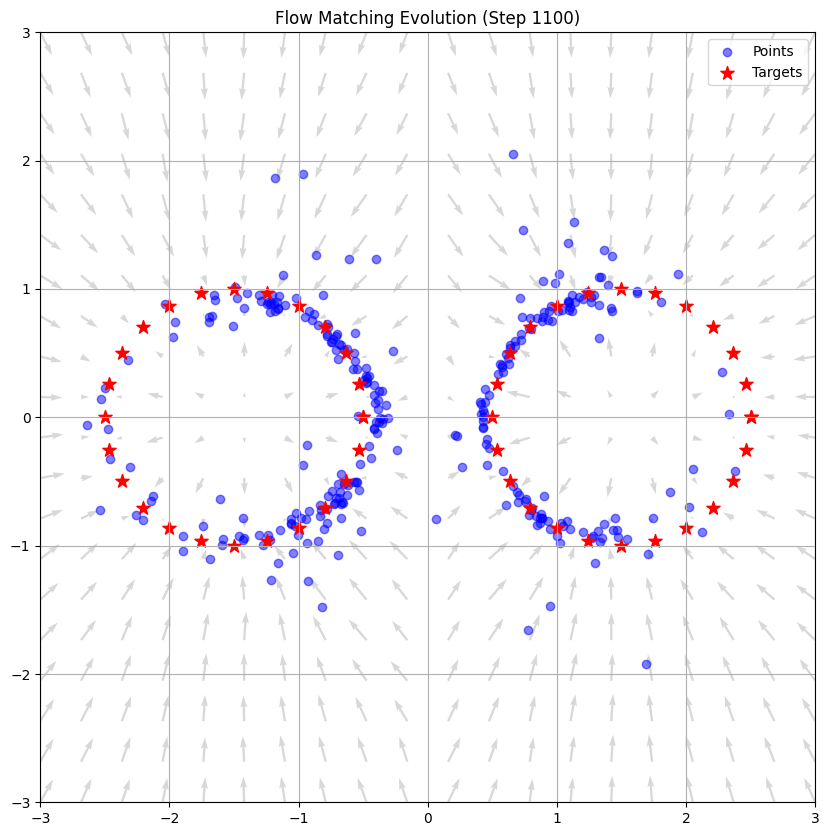

 79%|███████▉  | 1186/1500 [00:07<00:01, 177.39it/s]

Step 1200, Loss: 0.0472


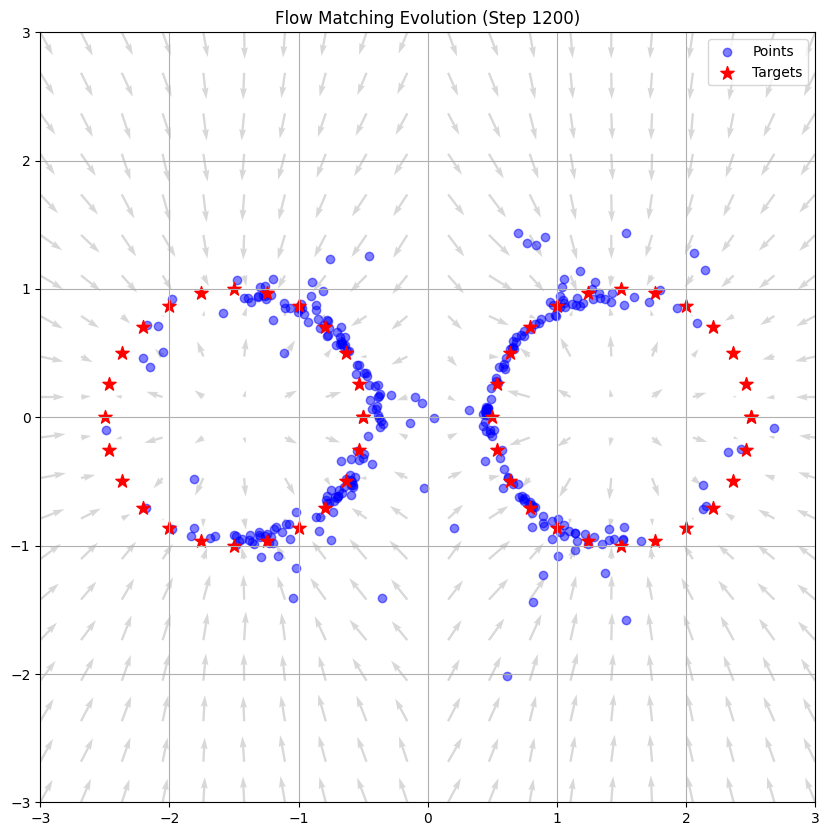

 85%|████████▌ | 1279/1500 [00:08<00:01, 127.28it/s]

Step 1300, Loss: 0.0427


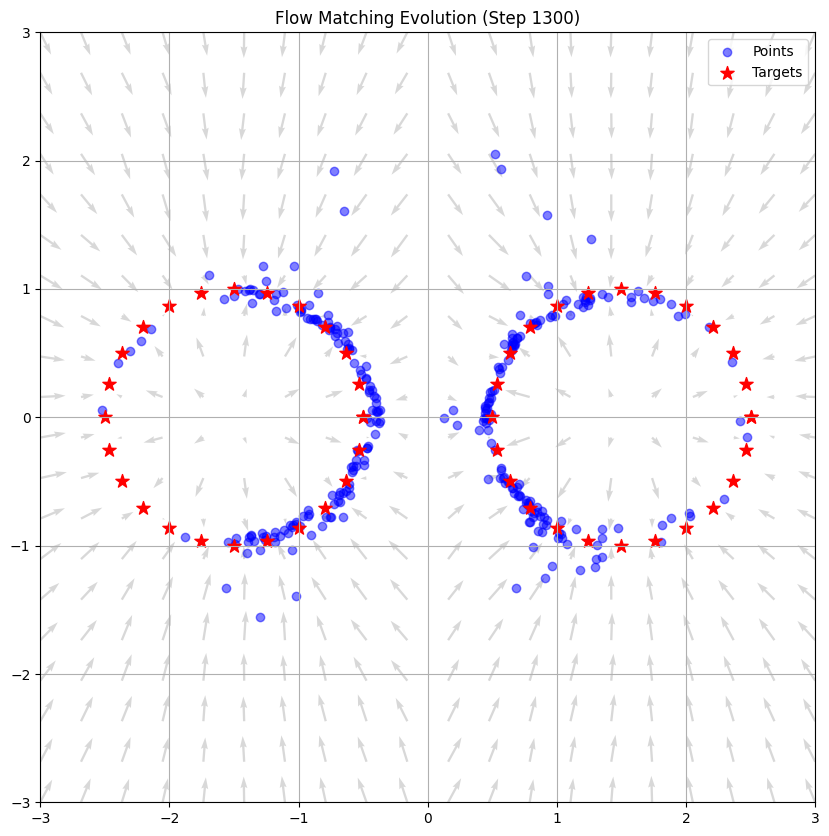

 92%|█████████▏| 1379/1500 [00:09<00:00, 134.39it/s]

Step 1400, Loss: 0.0395


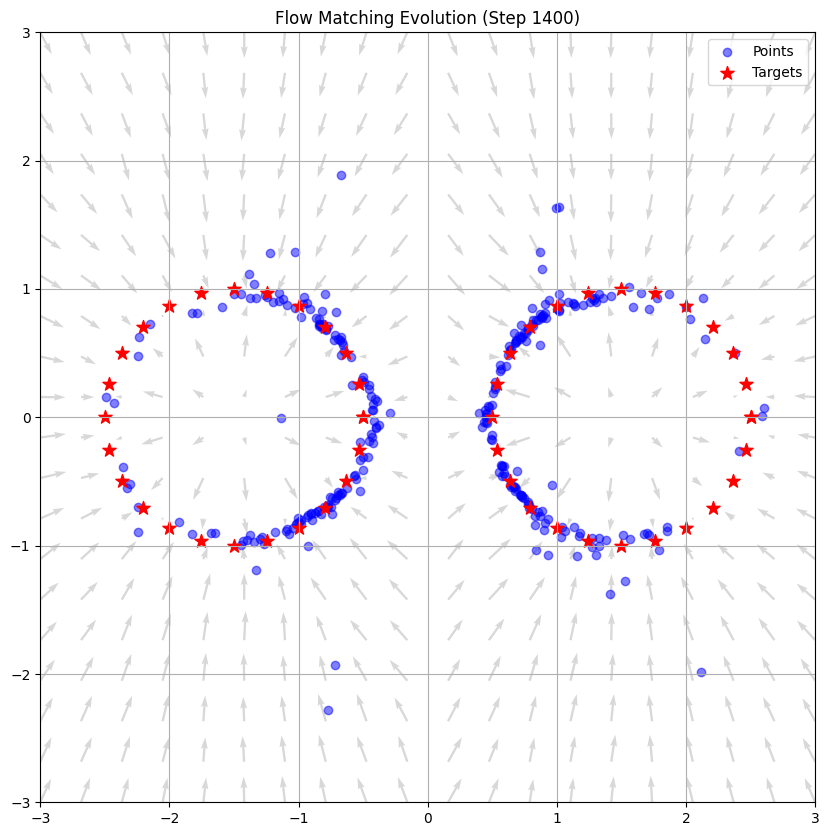

100%|█████████▉| 1495/1500 [00:11<00:00, 160.13it/s]

Step 1500, Loss: 0.0388


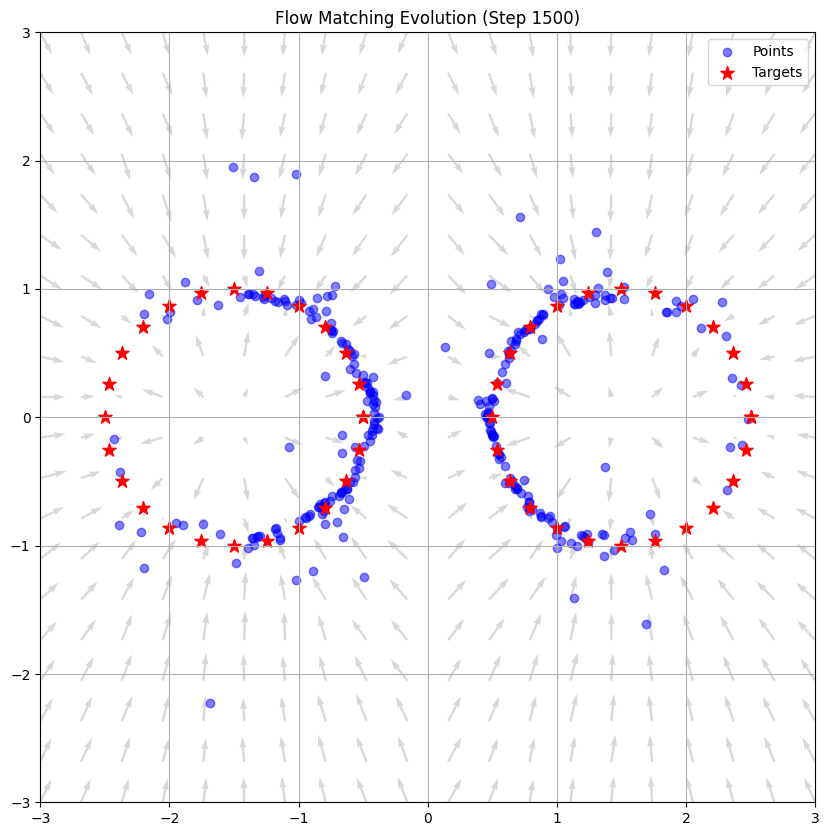

100%|██████████| 1500/1500 [00:11<00:00, 131.34it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio

class VectorField(nn.Module):
    def __init__(self, dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x, t):
        xt = torch.cat([x, t], dim=-1)
        return self.net(xt)

class FlowMatching:
    def __init__(self, dim=2):
        self.dim = dim
        self.device = 'cpu'
        self.vector_field = VectorField(dim).to(self.device)
        self.optimizer = optim.Adam(self.vector_field.parameters(), lr=1e-3)

    def create_circle_target(self, n_points=20, radius = 1.0):
        """Create target points in a circle"""
        theta = np.linspace(0, 2*np.pi, n_points)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)

    def generate_two_circles_targets(self, n_points: int = 50) -> torch.Tensor:
      """Generate target points in two circles"""
      circle1 = self.create_circle_target(n_points//2, radius=1.0) + torch.tensor([-1.5, 0.0])
      circle2 = self.create_circle_target(n_points//2, radius=1.0) + torch.tensor([1.5, 0.0])
      return torch.cat([circle1, circle2], dim=0)


    def train_step(self, target_points):
        self.vector_field.train()

        # Sample random points in the space
        x0 = torch.randn(1500, 2) * 3.0  # Sample more points for better coverage
        t = torch.rand(1500, 1)

        # Target vectors should point towards nearest target point
        dists = torch.cdist(x0, target_points)
        nearest_target = target_points[torch.argmin(dists, dim=1)]
        target_vectors = (nearest_target - x0) / torch.norm(nearest_target - x0, dim=1, keepdim=True).clamp(min=1e-5)

        # Predict vector field
        pred_vectors = self.vector_field(x0, t)

        # Loss is MSE between predicted and target vectors
        loss = torch.mean((pred_vectors - target_vectors) ** 2)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def get_vector_field(self, grid_size=20):
        """Compute vector field on a grid"""
        x = np.linspace(-3, 3, grid_size)
        y = np.linspace(-3, 3, grid_size)
        X, Y = np.meshgrid(x, y)

        points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
        t = torch.ones(len(points), 1) * 0.5  # middle time step

        with torch.no_grad():
            vectors = self.vector_field(points, t)

        return X, Y, vectors.reshape(grid_size, grid_size, 2).numpy()

    def simulate_flow(self, n_points=300, n_steps=100):
        """Simulate flow of points under the vector field"""
        self.vector_field.eval()

        # Initialize random points
        points = torch.randn(n_points, 2)
        trajectories = [points.clone()]

        dt = 1.0 / n_steps
        for step in range(n_steps):
            t = torch.ones(len(points), 1) * step * dt

            with torch.no_grad():
                # Update points using vector field
                velocity = self.vector_field(points, t)
                points = points + velocity * dt

            trajectories.append(points.clone())

        return torch.stack(trajectories)




def visualize_flow_matching(model, target_points, step, grid_size=20):
    """Visualize the current state of flow matching"""
    plt.figure(figsize=(10, 10))
    plt.title(f'Flow Matching Evolution (Step {step})')

    # Plot vector field
    X, Y, vectors = model.get_vector_field(grid_size)
    plt.quiver(X, Y, vectors[:,:,0], vectors[:,:,1],
              alpha=0.3, color='gray', scale=30)

    # Plot current points
    flow = model.simulate_flow()
    current_points = flow[-1]
    plt.scatter(current_points[:,0], current_points[:,1],
               c='blue', alpha=0.5, label='Points')

    # Plot target points
    plt.scatter(target_points[:,0], target_points[:,1],
               c='red', marker='*', s=100, label='Targets')

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_flow(model, target_points, n_points=500):
    """Visualize the flow field and trajectories over time as an animation."""
    # Create grid of points for vector field visualization
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    t = torch.ones(len(grid_points), 1) * 0.5  # Middle time step for uniform visualization

    # Compute vector field at grid points
    with torch.no_grad():
        vectors = model.vector_field(grid_points, t)

    U = vectors[:, 0].numpy().reshape(X.shape)
    V = vectors[:, 1].numpy().reshape(X.shape)

    # Generate initial random points and compute trajectory
    trajectory = model.simulate_flow(n_points=n_points, n_steps=100)

    # Create animation
    fig, ax = plt.subplots(figsize=(10, 10))

    def animate(frame):
        ax.clear()

        # Plot vector field
        ax.quiver(X, Y, U, V, alpha=0.3, color='gray', scale=30)

        # Plot target points
        ax.scatter(target_points[:, 0], target_points[:, 1],
                   c='red', marker='*', s=100, label='Targets')

        # Plot points at current frame
        current_points = trajectory[frame]
        ax.scatter(current_points[:, 0], current_points[:, 1],
                   c='blue', alpha=0.5, label='Points')

        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title(f'Flow Matching Evolution (Step {frame})')
        ax.legend()
        ax.grid(True)

    ani = animation.FuncAnimation(fig, animate, frames=len(trajectory),
                                  interval=50, repeat=True)
    plt.close()
    return ani



# Training loop
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize model and target points
    model = FlowMatching()
    target_points = model.generate_two_circles_targets()

    # Training loop
    n_steps = 1500
    for step in tqdm(range(n_steps)):
        loss = model.train_step(target_points)

        if (step + 1) % 100 == 0:
            print(f"Step {step + 1}, Loss: {loss:.4f}")
            visualize_flow_matching(model, target_points, step + 1)


    ani = visualize_flow(model, target_points)
    ani.save('flow_matching.gif', writer='pillow')


  5%|▌         | 81/1500 [00:01<00:17, 81.25it/s]

Step 100, Loss: 0.1526


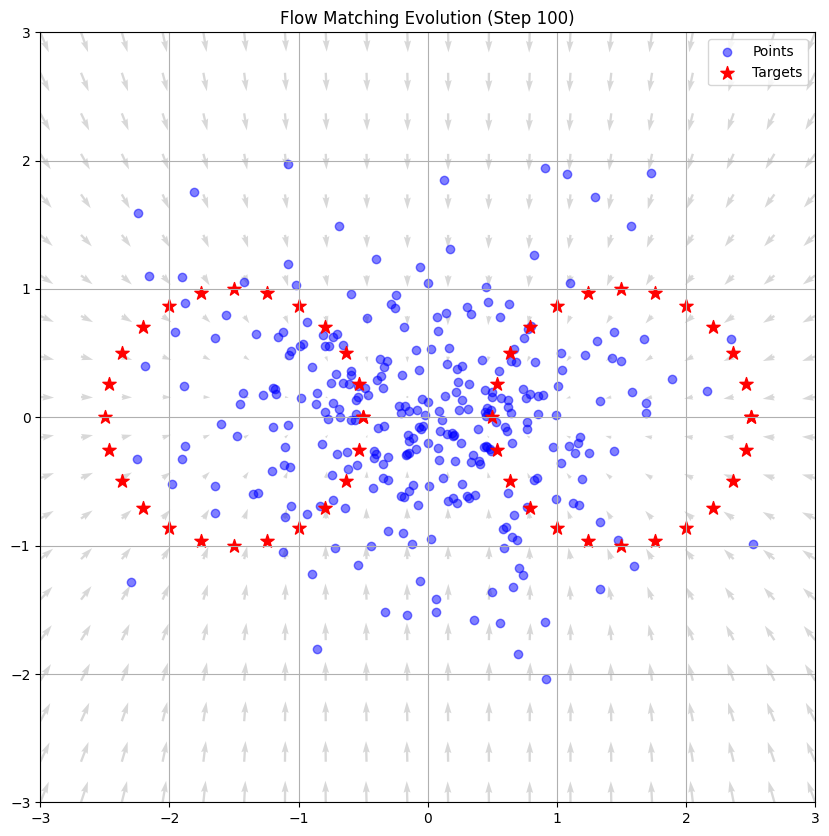

 13%|█▎        | 191/1500 [00:02<00:11, 113.68it/s]

Step 200, Loss: 0.1336


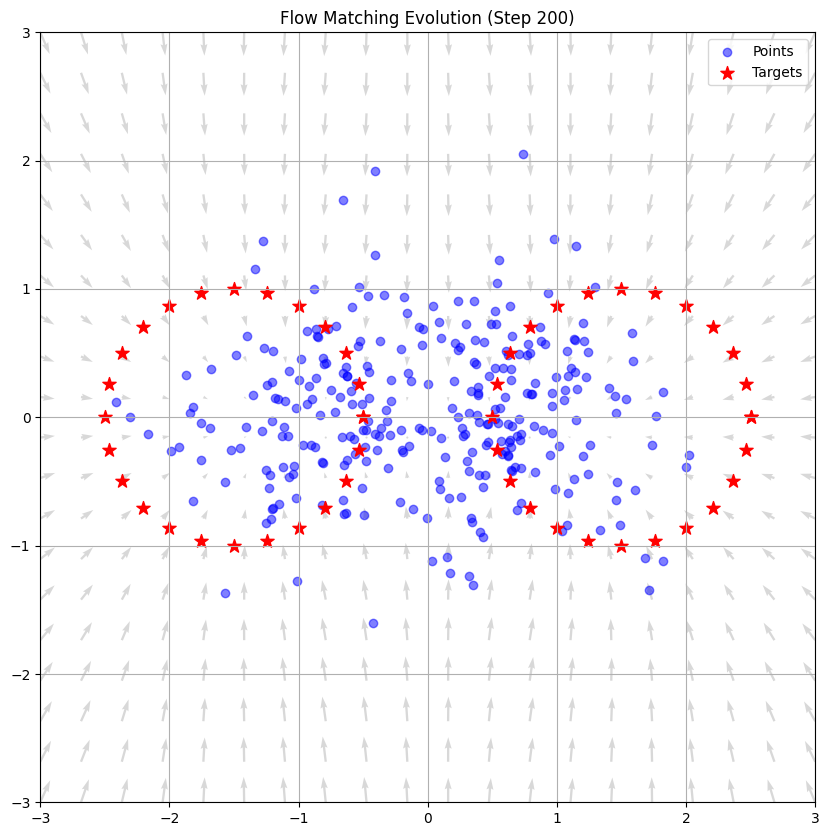

 19%|█▉        | 290/1500 [00:04<00:11, 101.61it/s]

Step 300, Loss: 0.1185


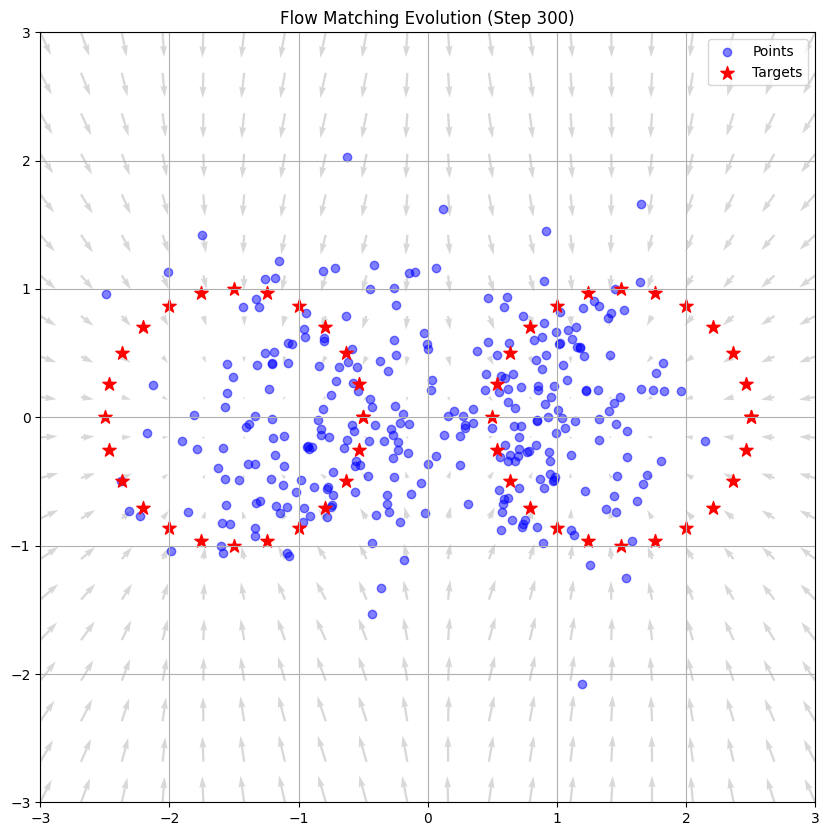

 25%|██▌       | 381/1500 [00:04<00:08, 133.80it/s]

Step 400, Loss: 0.1093


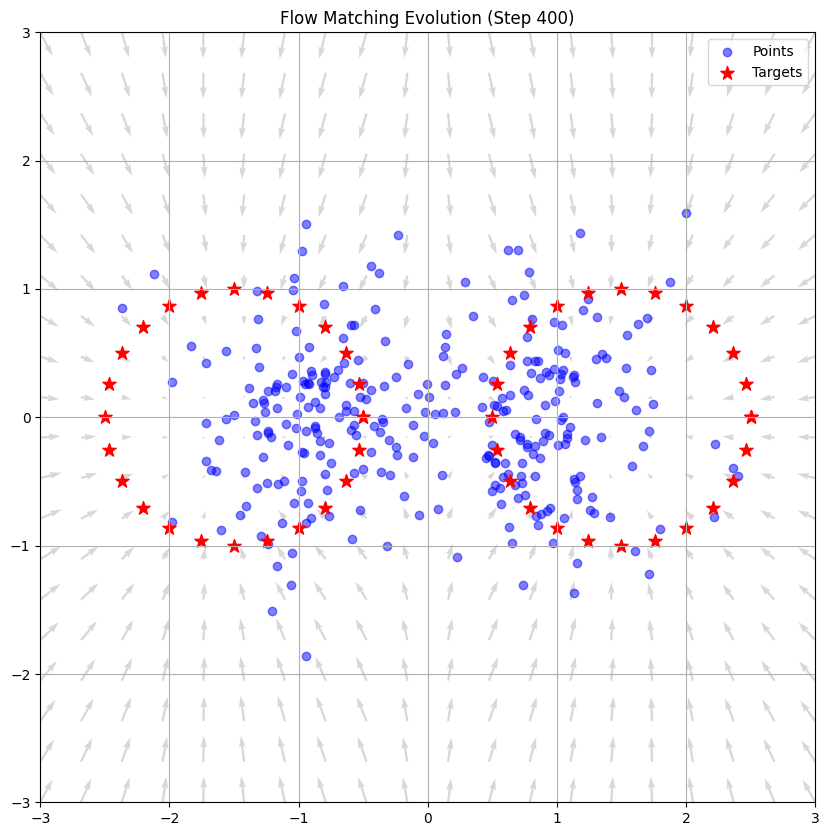

 32%|███▏      | 482/1500 [00:05<00:07, 144.41it/s]

Step 500, Loss: 0.1001


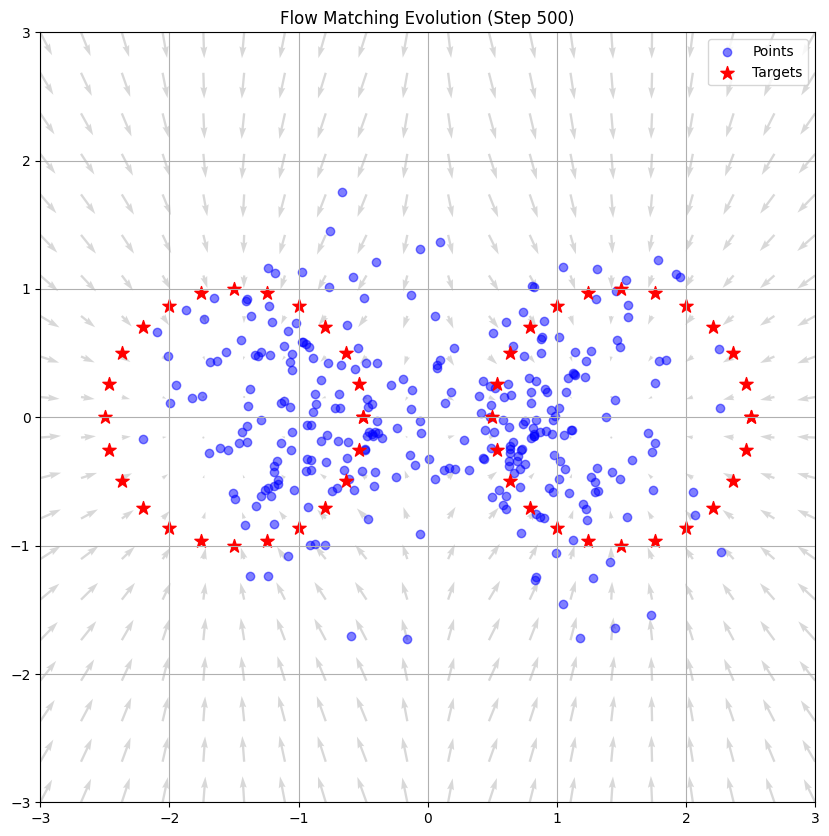

 39%|███▉      | 585/1500 [00:06<00:06, 152.32it/s]

Step 600, Loss: 0.0975


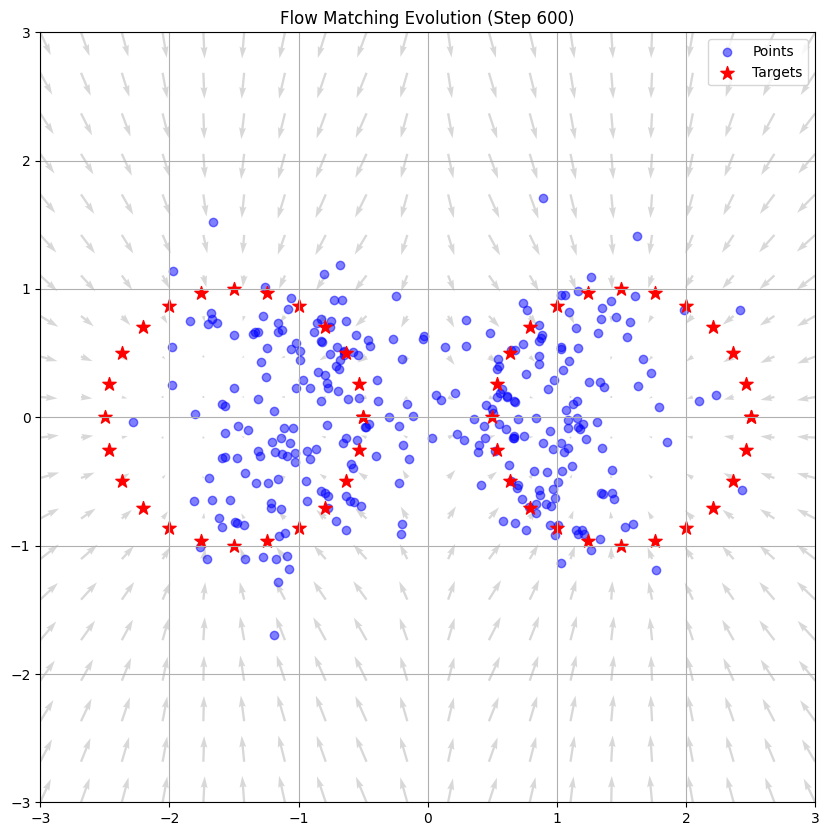

 46%|████▌     | 693/1500 [00:07<00:05, 156.29it/s]

Step 700, Loss: 0.0978


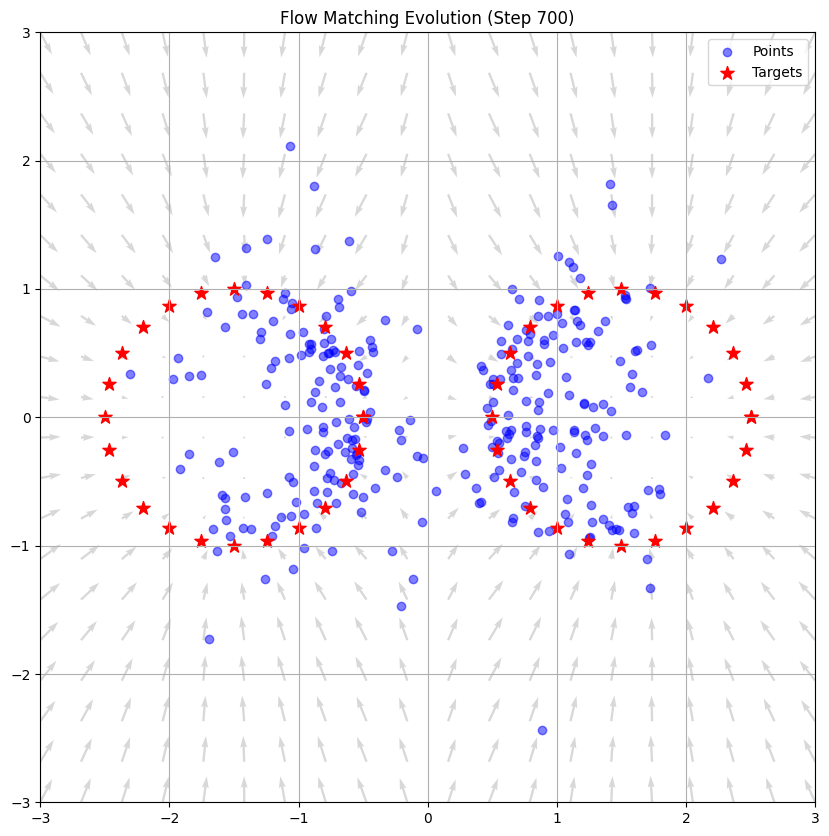

 52%|█████▏    | 780/1500 [00:08<00:05, 138.61it/s]

Step 800, Loss: 0.0794


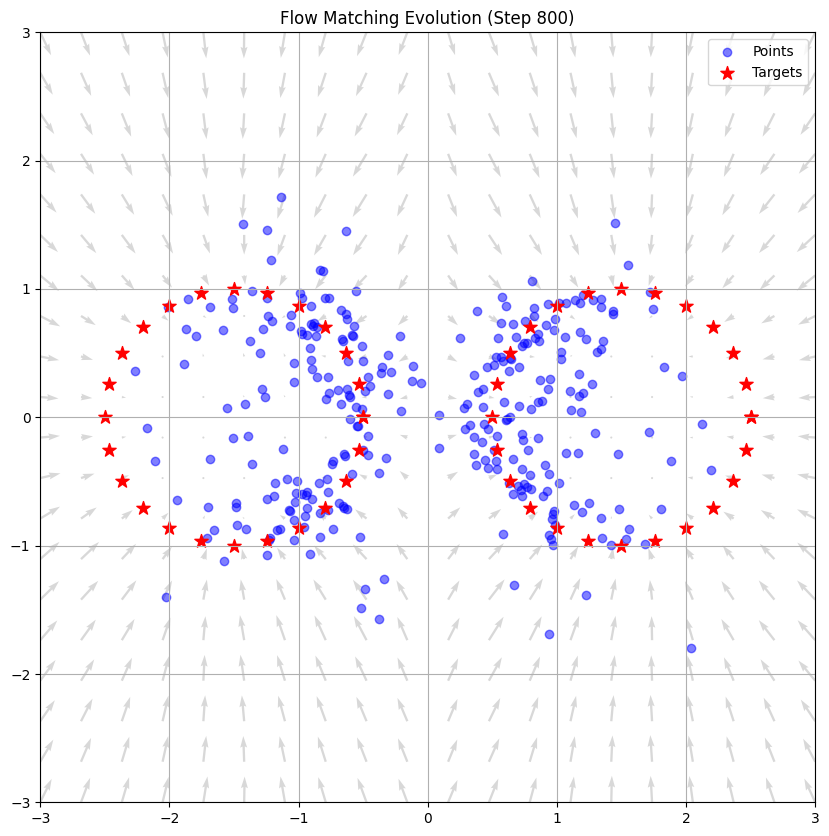

 60%|█████▉    | 898/1500 [00:09<00:03, 158.30it/s]

Step 900, Loss: 0.0723


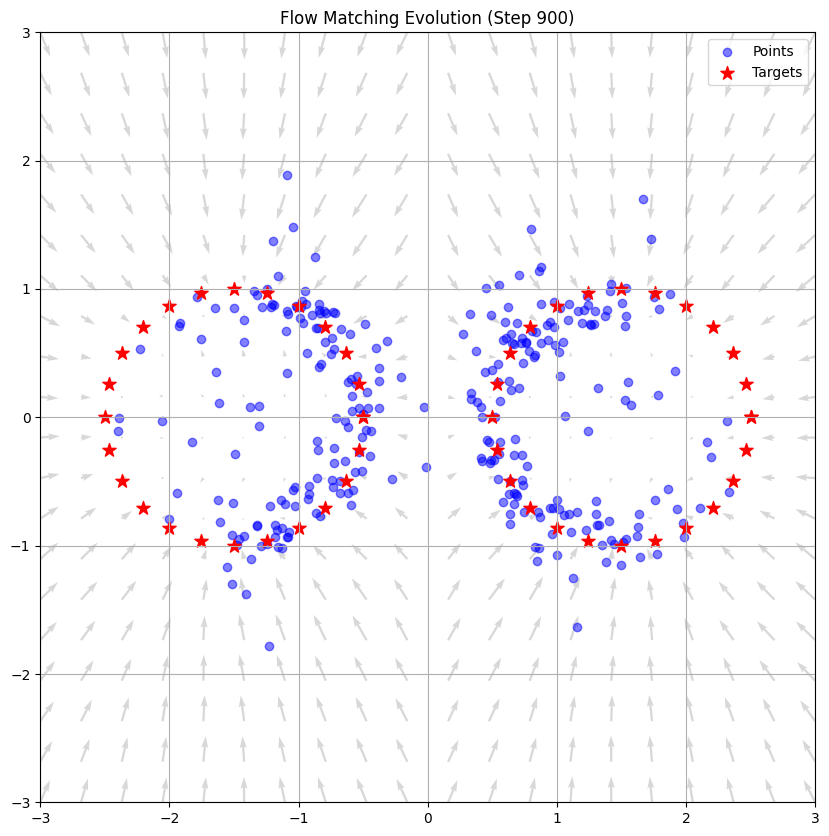

 65%|██████▌   | 982/1500 [00:10<00:03, 131.98it/s]

Step 1000, Loss: 0.0726


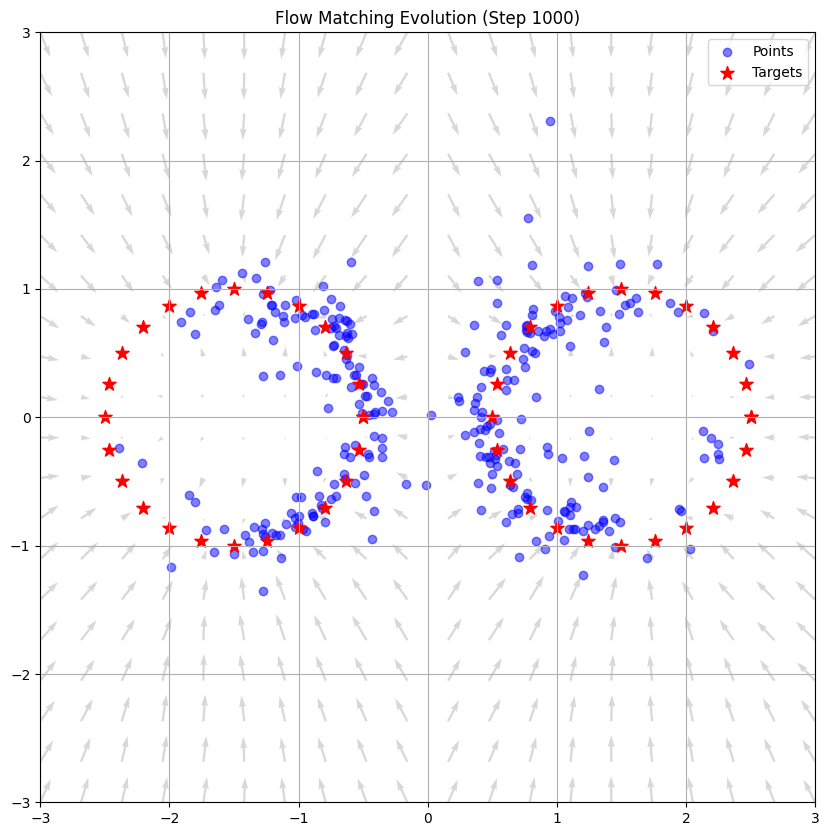

 73%|███████▎  | 1088/1500 [00:11<00:03, 121.67it/s]

Step 1100, Loss: 0.0577


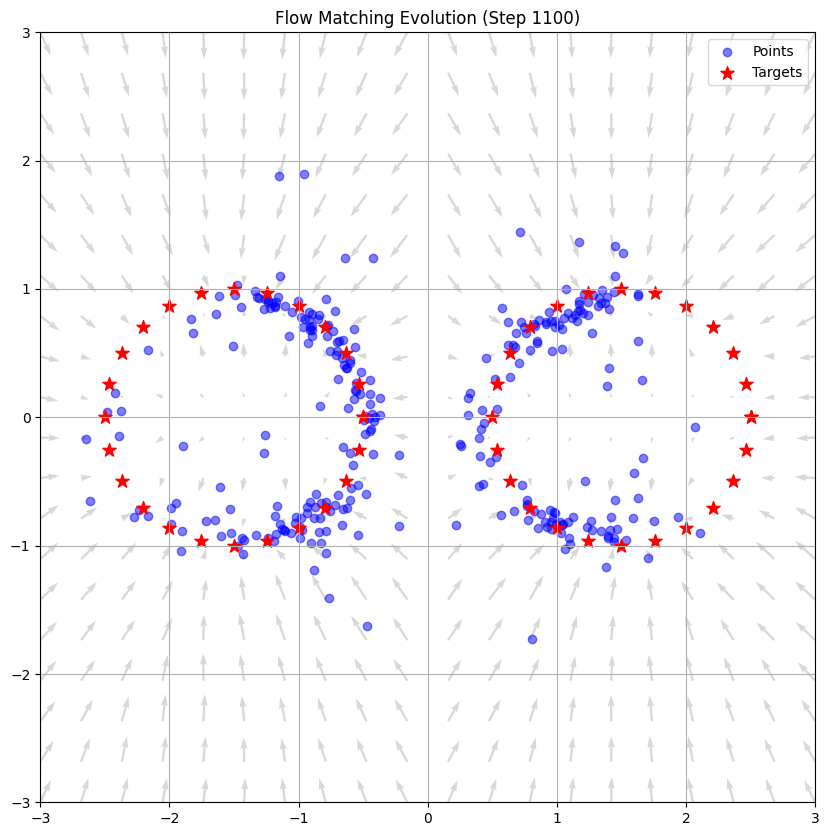

 79%|███████▉  | 1188/1500 [00:13<00:02, 104.33it/s]

Step 1200, Loss: 0.0568


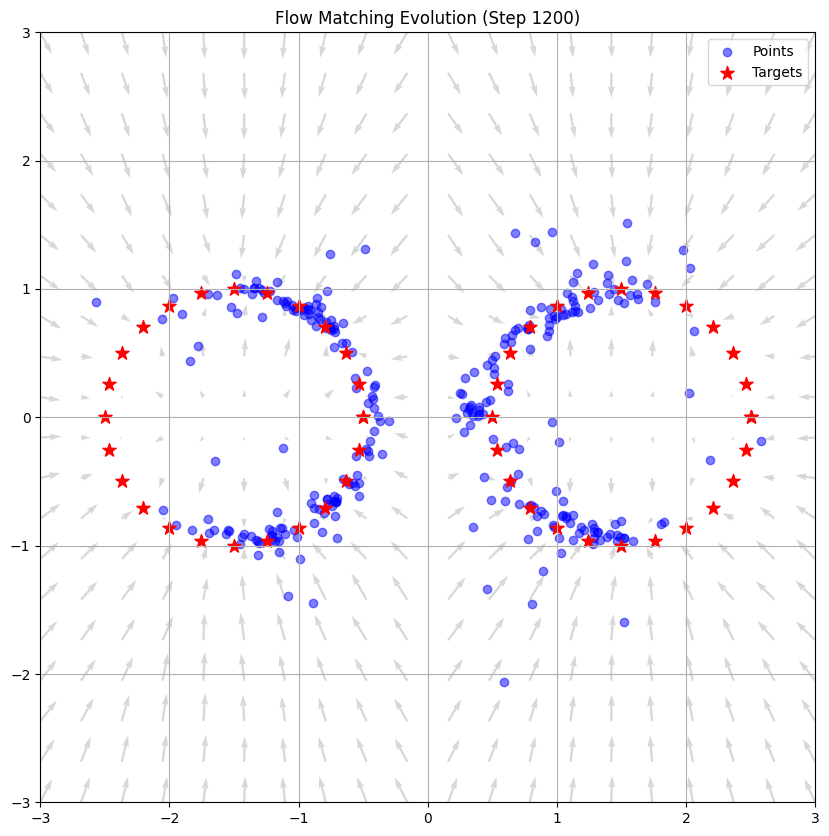

 87%|████████▋ | 1299/1500 [00:14<00:01, 106.92it/s]

Step 1300, Loss: 0.0535


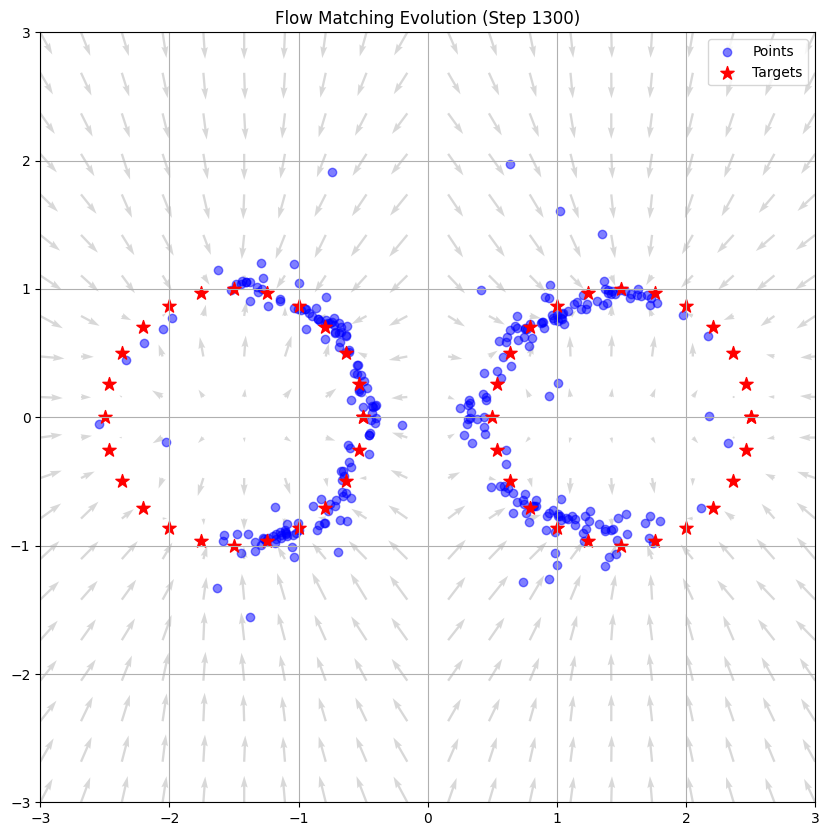

 93%|█████████▎| 1396/1500 [00:15<00:00, 135.24it/s]

Step 1400, Loss: 0.0480


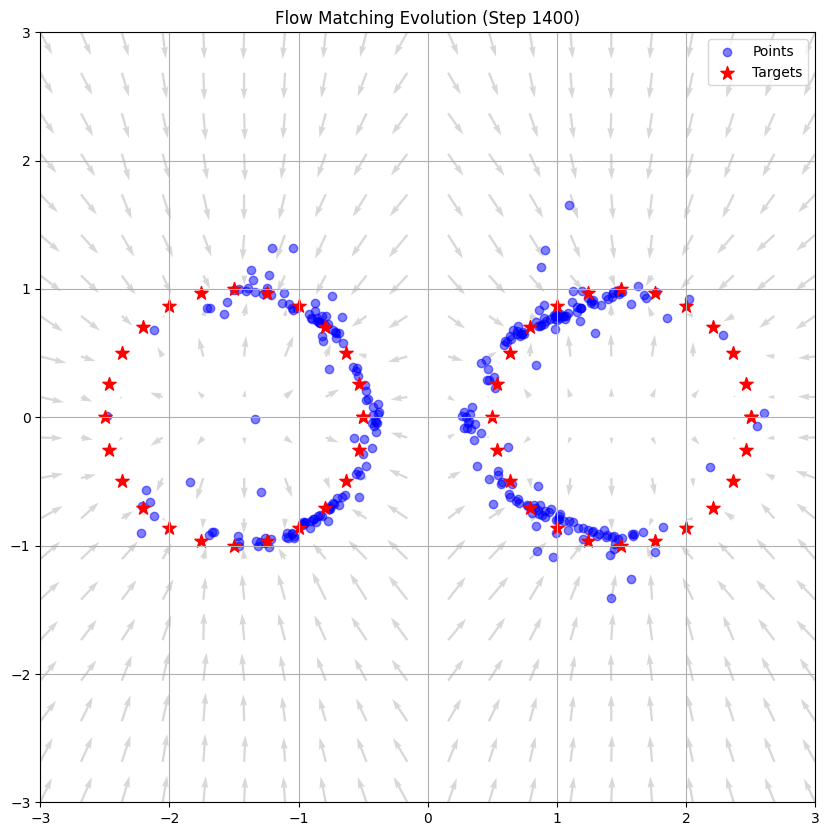

100%|█████████▉| 1493/1500 [00:16<00:00, 123.25it/s]

Step 1500, Loss: 0.0456


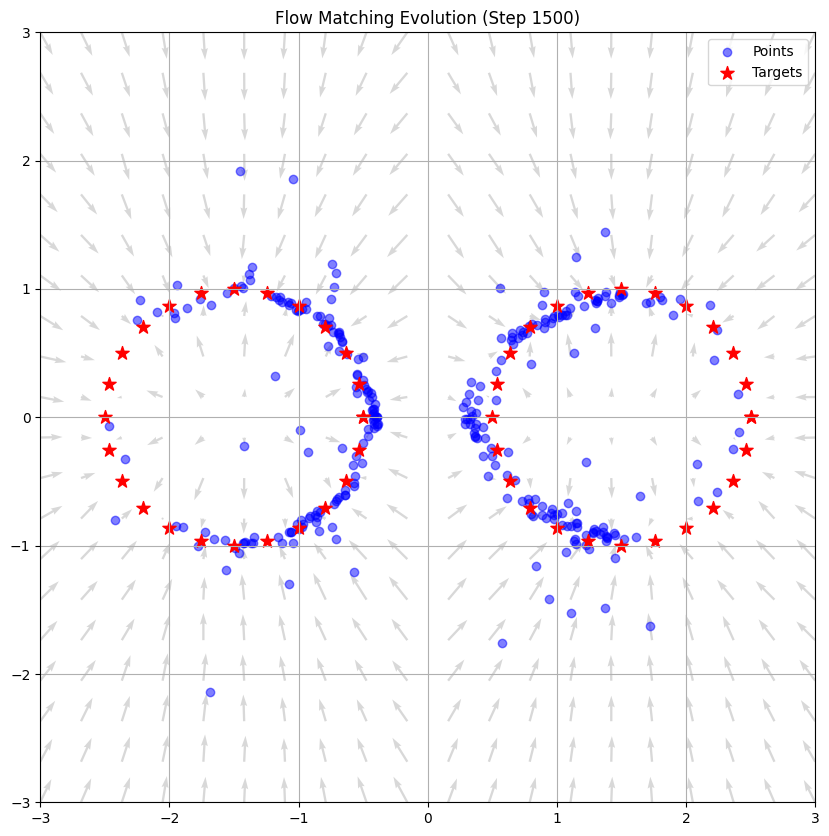

100%|██████████| 1500/1500 [00:17<00:00, 85.72it/s] 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio
import matplotlib.animation as animation

class VectorField(nn.Module):
    def __init__(self, dim=2, hidden_dim=64, cond_dim=2):
        super().__init__()
        # Extend the network to accept conditioning inputs as well
        self.net = nn.Sequential(
            nn.Linear(dim + 1 + cond_dim, hidden_dim),  # input includes x, t, and c
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x, t, c):
        xtc = torch.cat([x, t, c], dim=-1)
        return self.net(xtc)

class FlowMatching:
    def __init__(self, dim=2, cond_dim=2):
        self.dim = dim
        self.device = 'cpu'
        self.vector_field = VectorField(dim, cond_dim=cond_dim).to(self.device)
        self.optimizer = optim.Adam(self.vector_field.parameters(), lr=1e-3)

    def create_circle_target(self, n_points=20, radius=1.0):
        """Create target points in a circle"""
        theta = np.linspace(0, 2 * np.pi, n_points)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return torch.tensor(np.stack([x, y], axis=1), dtype=torch.float32)

    def generate_two_circles_targets(self, n_points=50) -> torch.Tensor:
        """Generate target points in two circles"""
        circle1 = self.create_circle_target(n_points // 2, radius=1.0) + torch.tensor([-1.5, 0.0])
        circle2 = self.create_circle_target(n_points // 2, radius=1.0) + torch.tensor([1.5, 0.0])
        return torch.cat([circle1, circle2], dim=0)

    def train_step(self, target_points):
        self.vector_field.train()

        # Sample random points in the space
        x0 = torch.randn(1500, 2) * 3.0  # Initial points
        t = torch.rand(1500, 1)  # Random time step between 0 and 1

        # Find the nearest target point for each starting point
        dists = torch.cdist(x0, target_points)
        nearest_target_indices = torch.argmin(dists, dim=1)
        nearest_targets = target_points[nearest_target_indices]

        # Use the nearest target as conditioning input
        conditioning = nearest_targets

        # Predict the vector field using the conditioning
        pred_vectors = self.vector_field(x0, t, conditioning)

        # Target vectors should point towards the nearest target
        target_vectors = (nearest_targets - x0) / torch.norm(nearest_targets - x0, dim=1, keepdim=True).clamp(min=1e-5)

        # Loss function: MSE between predicted and actual target vectors
        loss = torch.mean((pred_vectors - target_vectors) ** 2)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def simulate_flow(self, n_points=300, n_steps=100, conditioning_info=None):
        """Simulate flow of points under the vector field with conditioning"""
        self.vector_field.eval()

        # Initialize random points
        points = torch.randn(n_points, 2)
        trajectories = [points.clone()]

        dt = 1.0 / n_steps
        for step in range(n_steps):
            t = torch.ones(len(points), 1) * step * dt

            # Apply conditioning
            c = conditioning_info.repeat(len(points), 1) if conditioning_info is not None else torch.zeros((len(points), 2))

            with torch.no_grad():
                # Update points using vector field
                velocity = self.vector_field(points, t, c)
                points = points + velocity * dt

            trajectories.append(points.clone())

        return torch.stack(trajectories)


    def get_vector_field(self, grid_size=20, conditioning_info=None):
        """Compute vector field on a grid with optional conditioning."""
        x = np.linspace(-3, 3, grid_size)
        y = np.linspace(-3, 3, grid_size)
        X, Y = np.meshgrid(x, y)

        points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
        t = torch.ones(len(points), 1) * 0.5  # Middle time step
        if conditioning_info is not None:
            c = conditioning_info.repeat(len(points), 1)  # Broadcast conditioning info
        else:
            c = torch.zeros((len(points), 2))  # Adjust based on your conditioning input size

        with torch.no_grad():
            vectors = self.vector_field(points, t, c)

        return X, Y, vectors.reshape(grid_size, grid_size, 2).numpy()

def visualize_flow(model, target_points, conditioning_info, n_points=500):
    """Visualize the flow field and trajectories over time as an animation with conditioning."""
    # Create grid of points for vector field visualization
    x = np.linspace(-3, 3, 20)
    y = np.linspace(-3, 3, 20)
    X, Y = np.meshgrid(x, y)

    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    t = torch.ones(len(grid_points), 1) * 0.5  # Middle time step for uniform visualization
    c = conditioning_info.repeat(len(grid_points), 1)

    # Compute vector field at grid points
    with torch.no_grad():
        vectors = model.vector_field(grid_points, t, c)

    U = vectors[:, 0].numpy().reshape(X.shape)
    V = vectors[:, 1].numpy().reshape(X.shape)

    # Generate initial random points and compute trajectory
    trajectory = model.simulate_flow(n_points=n_points, n_steps=100, conditioning_info=conditioning_info)

    # Create animation
    fig, ax = plt.subplots(figsize=(10, 10))

    def animate(frame):
        ax.clear()

        # Plot vector field
        ax.quiver(X, Y, U, V, alpha=0.3, color='gray', scale=30)

        # Plot target points
        ax.scatter(target_points[:, 0], target_points[:, 1], c='red', marker='*', s=100, label='Targets')

        # Plot points at current frame
        current_points = trajectory[frame]
        ax.scatter(current_points[:, 0], current_points[:, 1], c='blue', alpha=0.5, label='Points')

        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_title(f'Flow Matching Evolution (Step {frame})')
        ax.legend()
        ax.grid(True)

    ani = animation.FuncAnimation(fig, animate, frames=len(trajectory), interval=50, repeat=True)
    plt.close()
    return ani

def visualize_flow_matching(model, target_points, step, grid_size=20, conditioning_info=None):
    """Visualize the current state of flow matching with conditioning."""
    plt.figure(figsize=(10, 10))
    plt.title(f'Flow Matching Evolution (Step {step})')

    # Plot vector field
    X, Y, vectors = model.get_vector_field(grid_size, conditioning_info)
    plt.quiver(X, Y, vectors[:, :, 0], vectors[:, :, 1], alpha=0.3, color='gray', scale=30)

    # Plot current points at the final frame of the simulated flow
    flow = model.simulate_flow(conditioning_info=conditioning_info)
    current_points = flow[-1]
    plt.scatter(current_points[:, 0], current_points[:, 1], c='blue', alpha=0.5, label='Points')

    # Plot target points
    plt.scatter(target_points[:, 0], target_points[:, 1], c='red', marker='*', s=100, label='Targets')

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    plt.grid(True)
    plt.show()


# Simulated environment for dynamic conditioning
def generate_dynamic_conditioning(step, total_steps):
    """Simulate a changing conditioning vector over time."""
    # Example: Move the target from left (-1, 0) to right (1, 0) linearly
    progress = step / total_steps
    x = -1.0 + 2.0 * progress  # Linear transition from -1 to 1
    y = 0.5 * np.sin(2 * np.pi * progress)  # Example sinusoidal change for variation
    return torch.tensor([x, y], dtype=torch.float32)

# Training loop with dynamic conditioning
if __name__ == "__main__":
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Initialize model and target points
    model = FlowMatching()
    target_points = model.generate_two_circles_targets()

    # Training loop
    n_steps = 1500
    for step in tqdm(range(n_steps)):
        # Simulate dynamic conditioning that changes over time
        conditioning_info = generate_dynamic_conditioning(step, n_steps)
        loss = model.train_step(target_points, conditioning_info)

        if (step + 1) % 100 == 0:
            print(f"Step {step + 1}, Loss: {loss:.4f}")
            visualize_flow_matching(model, target_points, step + 1)

    ani = visualize_flow(model, target_points, generate_dynamic_conditioning(n_steps - 1, n_steps))
    ani.save('flow_matching_dynamic_conditions.gif', writer='pillow')

    ani = visualize_flow(model, target_points, generate_dynamic_conditioning(1, n_steps))
    ani.save('flow_matching_dynamic_conditions_1.gif', writer='pillow')
